In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
!pip install mlxtend --upgrade
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, precision_score, accuracy_score, recall_score
from sklearn.svm import SVC
from matplotlib import pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTENC
import os
import tempfile
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier
from keras import optimizers, models, layers
from keras.callbacks import ModelCheckpoint
import warnings
!pip install shap
import shap
import statsmodels.api as sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
no display found. Using non-interactive Agg backend
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


**POST_EDA_DATA (NO_SAMP)**

In [2]:
# Reading Data
data=pd.read_csv('post_eda_data.csv')
data.drop(columns=['Unnamed: 0','PWEIGHT','BIN_2_PASRFNMG'],inplace=True)
cat_data=['PATTCRR','PATTCRU','D_PATTCRU','PATTLCP','PATTPAYD','PATTRSA','PATTRSH','PATTRSL','PATTRSP','PATTRSR','PATTSTIN','PEFMJSIF','PFRSPST',
'D_PWARRIF','D_PWARRSPL','D_PWASTMUI','D_PWATOTPT','D_PWDSLOAN','D_PWDSTODB','D1_PWNETWPT','D2_PWNETWPT','PASRDPO1','PASRDPO2','PASRDPO3','PASRDPO4',
'PASRDPO5','PASRRNTG','PFTENUR','D_PFTENUR','PFMTYPG','PLFCHRME','PLFFPTME','PLFPDMEG','PRETIRME']
data.PATTSKP.replace(to_replace=[2],value=[0],inplace=True)
data[cat_data]=data[cat_data].astype('category')
print('Data Shape:',data.shape)
# Creating two sets of variables - one includes transformed variables and drops base variables, the other does exactly the opposite
bin1=[i for i in data.columns if i.startswith('BIN_1_')]
base_bin1=[i.replace('BIN_1_','') for i in bin1 ]
bin2=[i for i in data.columns if i.startswith('BIN_2_')]
base_bin2=[i.replace('BIN_2_','') for i in bin2 ]
log=[i for i in data.columns if i.startswith('LOG_1_')]
base_log=[i.replace('LOG_1_','') for i in log ]
transformed_variables=log+bin1+bin2
base_variables=base_bin1+base_bin2+base_log
trans_var=list(set(data.columns)-set(base_variables))
trans_data=data[trans_var]
base_var=list(set(data.columns)-set(transformed_variables))
base_data=data[base_var]
warnings.filterwarnings("ignore")

Data Shape: (8840, 92)


## BASE DATA (VARIABLES WITH NO TRANSFORMATIONS)

**DATA WITH CLASS IMBALANCE - NO DATA AUGMENTATION = no_samp**

In [3]:
# Data Partitioning and Variable Declaration
base_no_samp_X = base_data.drop(columns=['PATTSKP'])
base_no_samp_y = base_data['PATTSKP']
base_no_samp_train_X, base_no_samp_valid_X, base_no_samp_train_y, base_no_samp_valid_y = train_test_split(base_no_samp_X,base_no_samp_y, test_size=0.5, random_state=1)
print('PATTSKP - Value Counts\n    Yes: {}\n    No: {}'.format(data.PATTSKP.value_counts()[1],data.PATTSKP.value_counts()[0]))

PATTSKP - Value Counts
    Yes: 646
    No: 8194


In [4]:
# Full Classification Tree - BASE-NO_SAMP
fullClassTree_b_ns = DecisionTreeClassifier(random_state=1).fit(base_no_samp_train_X,base_no_samp_train_y)
acc_fct_b_ns=classificationSummary(base_no_samp_valid_y,fullClassTree_b_ns.predict(base_no_samp_valid_X))
# AUCROC
prob_y = fullClassTree_b_ns.predict_proba(base_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_fct_b_ns=roc_auc_score(base_no_samp_valid_y,prob_y)
fullClassTree_b_ns_acc_train=fullClassTree_b_ns.score(base_no_samp_train_X, base_no_samp_train_y)
print("\nAUCROC: {:.4f}\nTraining Accuracy: {:.2f}".format(roc_fct_b_ns,fullClassTree_b_ns_acc_train))

Confusion Matrix (Accuracy 0.8688)

       Prediction
Actual    0    1
     0 3786  289
     1  291   54

AUCROC: 0.5428
Training Accuracy: 1.00


Confusion Matrix (Accuracy 0.9219)

       Prediction
Actual    0    1
     0 4075    0
     1  345    0

Random Forest Classifier (Base-No_Samp) AUCROC: 0.7959
Training Accuracy: 0.9319



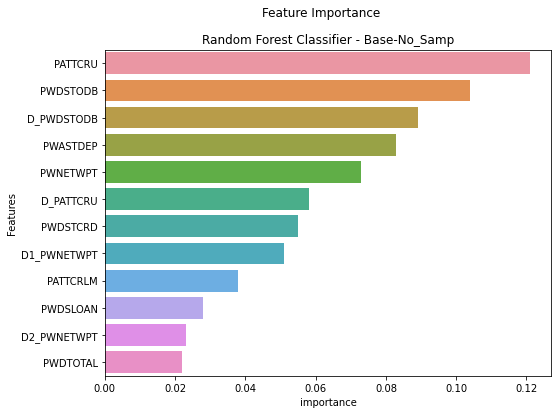

In [5]:
# Random Forest Classifier - BASE-NO_SAMP
rfc_b_ns = RandomForestClassifier(random_state=123, n_estimators=750, max_depth=3).fit(base_no_samp_train_X, base_no_samp_train_y)
acc_rfc_b_ns=classificationSummary(base_no_samp_valid_y, rfc_b_ns.predict(base_no_samp_valid_X))
# AUROC
prob_y = rfc_b_ns.predict_proba(base_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_rfc_b_ns=roc_auc_score(base_no_samp_valid_y,prob_y)
rfc_b_ns_acc_train=rfc_b_ns.score(base_no_samp_train_X, base_no_samp_train_y)
print("\nRandom Forest Classifier (Base-No_Samp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_rfc_b_ns,rfc_b_ns_acc_train))
# Feature Importance
importance= rfc_b_ns.feature_importances_
df= pd.DataFrame({'feature': base_no_samp_train_X.columns, 'importance': np.round(importance,3)})
# Feature Importance Plot
selected_imp=df.sort_values('importance', ascending=False)[:12]
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("Random Forest Classifier - Base-No_Samp")
plt.show()

Confusion Matrix (Accuracy 0.9143)

       Prediction
Actual    0    1
     0 4010   65
     1  314   31

AdaBoost Decision Tree Classifier (Base-No_Samp) AUCROC: 0.6875
Training Accuracy: 1.0000



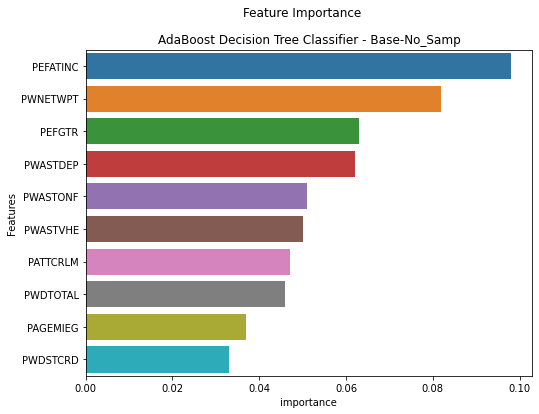

In [6]:
# AdaBoost Decision Tree Classifier - BASE-NO_SAMP
ada_b_ns=AdaBoostClassifier(DecisionTreeClassifier(random_state=123, max_depth=3),n_estimators=750, random_state=1).fit(base_no_samp_train_X, base_no_samp_train_y)
acc_ada_b_ns=classificationSummary(base_no_samp_valid_y, ada_b_ns.predict(base_no_samp_valid_X))
# AUROC
prob_y = ada_b_ns.predict_proba(base_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_ada_b_ns=roc_auc_score(base_no_samp_valid_y, prob_y)
ada_b_ns_acc_train=ada_b_ns.score(base_no_samp_train_X, base_no_samp_train_y)
print("\nAdaBoost Decision Tree Classifier (Base-No_Samp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_ada_b_ns,ada_b_ns_acc_train))
# Feature Importance
importance= ada_b_ns.feature_importances_
df= pd.DataFrame({'feature': base_no_samp_train_X.columns, 'importance': np.round(importance,3)})
selected_imp=df.sort_values('importance', ascending=False)[:10]
# Feature Importance Plot
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("AdaBoost Decision Tree Classifier - Base-No_Samp")

Confusion Matrix (Accuracy 0.6869)

       Prediction
Actual    0    1
     0 2790 1285
     1   99  246

Logistic Regression (Base-No_Samp) AUCROC: 0.7658
Training Accuracy: 0.6984

Shap Value Feature Importance Explainer Plot



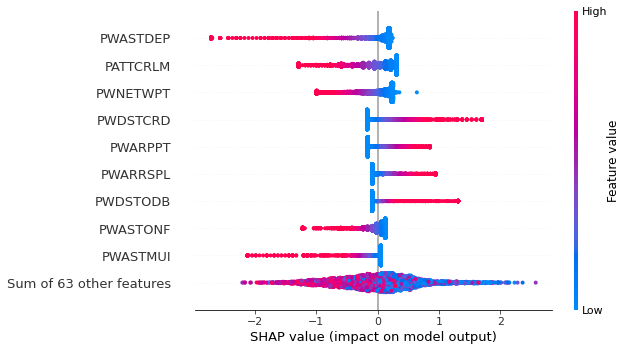

In [7]:
# Logistic Regression - BASE-No_Samp
LogReg_b_ns = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_no_samp_train_X, base_no_samp_train_y)
acc_log_b_ns=classificationSummary(base_no_samp_valid_y, LogReg_b_ns.predict(base_no_samp_valid_X))
# AUROC
prob_y = LogReg_b_ns.predict_proba(base_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
ROC_LOG_B_NS=roc_auc_score(base_no_samp_valid_y, prob_y)
LogRegACC_train=LogReg_b_ns.score(base_no_samp_train_X, base_no_samp_train_y)
print("\nLogistic Regression (Base-No_Samp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(ROC_LOG_B_NS,LogRegACC_train))
# Shap Explainer Plot
explainer_LogReg_b_ns = shap.Explainer(LogReg_b_ns, base_no_samp_train_X, feature_names=base_no_samp_train_X.columns.tolist())
shap_values_LogReg_b_ns = explainer_LogReg_b_ns(base_no_samp_train_X)
print('Shap Value Feature Importance Explainer Plot\n')
shap.plots.beeswarm(shap_values_LogReg_b_ns)

*Neural Network - Base-NO_SAMP*

Initial bias: -2.54
Weight for class 0: 0.54
Weight for class 1: 6.84



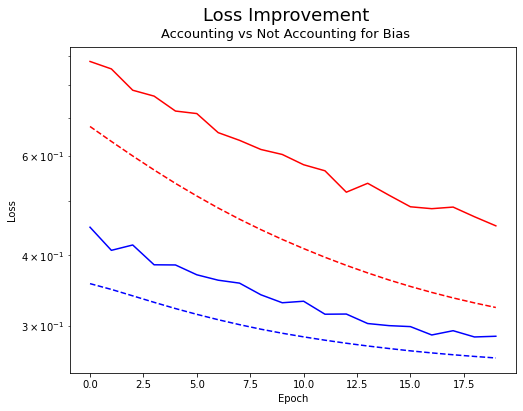



Restoring model weights from the end of the best epoch: 219.
Epoch 234: early stopping


Results:
    TN - FN: 3267 / 124
    FP - TP: 822 / 207

    Validation Accuracy: 0.786
    Validation AUC_ROC: 0.7907
    Validation Recall: 0.6254
    Precision: 0.2012



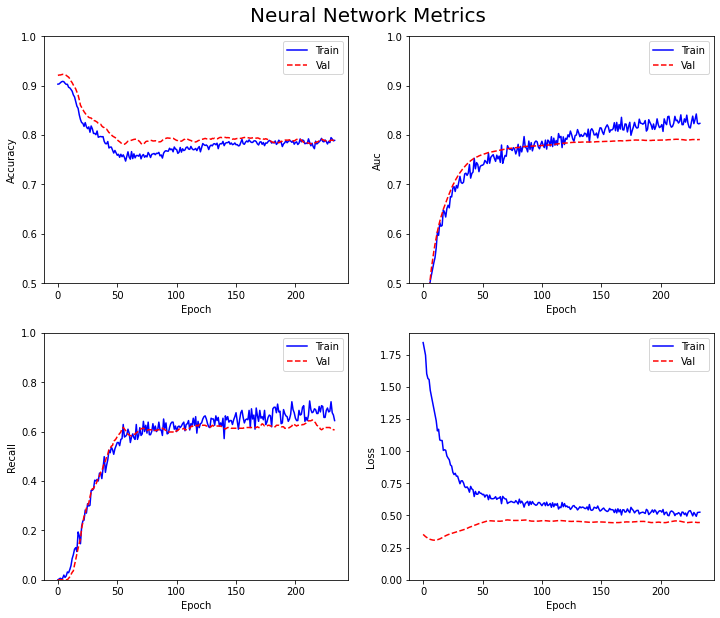

In [8]:
# Data Normalization for NN 

# Splitting data with no previous transformations into train-test-validation
train_df_b_ns, val_df_b_ns = train_test_split(base_data, test_size=0.5)
# Create np arrays of labels and features.
train_labels_b_ns = np.array(train_df_b_ns.pop('PATTSKP'))
bool_train_labels_b_ns = train_labels_b_ns != 0
val_labels_b_ns = np.array(val_df_b_ns.pop('PATTSKP'))
train_features_b_ns = np.array(train_df_b_ns)
val_features_b_ns = np.array(val_df_b_ns)
# Normalizing data
scaler = StandardScaler()
train_features_b_ns = scaler.fit_transform(train_features_b_ns)
val_features_b_ns = scaler.transform(val_features_b_ns)
# Eliminating outliers
train_features_b_ns = np.clip(train_features_b_ns, -5, 5)
val_features_b_ns = np.clip(val_features_b_ns, -5, 5)
# Defining positive and negative target responses - will be used to set the weights and bias
pos_df_b_ns = pd.DataFrame(train_features_b_ns[ bool_train_labels_b_ns], columns=train_df_b_ns.columns)
neg_df_b_ns = pd.DataFrame(train_features_b_ns[~bool_train_labels_b_ns], columns=train_df_b_ns.columns)
neg_b_ns, pos_b_ns = np.bincount(data['PATTSKP'])
total_b_ns = neg_b_ns + pos_b_ns
# Defining the initial bias of the model - avoiding the model only 'learns' the bias during first epochs there's class 
initial_bias_b_ns = np.log([pos_b_ns/neg_b_ns])
print('Initial bias:', round(initial_bias_b_ns[0],2))
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0_b_ns = (1/neg_b_ns)*(total_b_ns/2.0)
weight_for_1_b_ns = (1/pos_b_ns)*(total_b_ns/2.0)
class_weight_b_ns = {0: weight_for_0_b_ns, 1: weight_for_1_b_ns}
print('Weight for class 0: {:.2f}'.format(weight_for_0_b_ns))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1_b_ns))

                                              # Model - Initial Weights 
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),]
BATCH_SIZE=2000
# Construct the Model
output_bias_b_ns = tf.keras.initializers.Constant(initial_bias_b_ns)
weights_b_ns = keras.Sequential([
    keras.layers.Dense(12, activation='relu',input_shape=(train_features_b_ns.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias_b_ns),])
# Compile Model
weights_b_ns.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Evaluate
results_b_ns = weights_b_ns.evaluate(train_features_b_ns, train_labels_b_ns,batch_size=2000,verbose=0)
initial_weights_b_ns = os.path.join(tempfile.mkdtemp(), 'initial_weights_b_ns')
weights_b_ns.save_weights(initial_weights_b_ns)
# Visualizations of Loss Reduction for Model Accounting for Bias 
# Zero-bias model (Naive Initialization)
weights_b_ns.load_weights(initial_weights_b_ns)
weights_b_ns.layers[-1].bias.assign([0.0])
zero_bias_history = weights_b_ns.fit(train_features_b_ns,train_labels_b_ns,batch_size=BATCH_SIZE,epochs=20,validation_data=(val_features_b_ns, val_labels_b_ns), verbose=0)
# Pre-trained model
weights_b_ns.load_weights(initial_weights_b_ns)
accounts_bias_history = weights_b_ns.fit(train_features_b_ns,train_labels_b_ns,batch_size=BATCH_SIZE,epochs=20,validation_data=(val_features_b_ns, val_labels_b_ns), verbose=0)
# Visualization
loss, ax=plt.subplots(figsize=(8,6))
ax1=plt.semilogy(accounts_bias_history.epoch, accounts_bias_history.history['loss'],color='blue', )
ax1=plt.semilogy(accounts_bias_history.epoch, accounts_bias_history.history['val_loss'],color='blue', label='Val ', linestyle="--")
ax1=plt.semilogy(zero_bias_history.epoch, zero_bias_history.history['loss'],color='red', )
ax1=plt.semilogy(zero_bias_history.epoch, zero_bias_history.history['val_loss'],color='red', label='Val ', linestyle="--")
loss.text(x=0.5, y=0.94, s='Loss Improvement', fontsize=18, ha='center')
loss.text(x=0.5, y=0.90, s='Accounting vs Not Accounting for Bias', fontsize=13, ha='center')
ax1=plt.xlabel('Epoch')
ax1=plt.ylabel('Loss')
plt.show()
print('\n')
                                                        # Model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
# Construct the Model
nn_b_ns = keras.Sequential([
    keras.layers.Dense(12, activation='relu',input_shape=(train_features_b_ns.shape[-1],)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')])
# Compile Model
nn_b_ns.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Defining Additional Parameters
EPOCHS = 500
BATCH_SIZE = 2000
early_stopping_b_ns = tf.keras.callbacks.EarlyStopping(monitor='val_prc',verbose=1,patience=15,mode='max',restore_best_weights=True)
# Fit the model
nn_b_ns.load_weights(initial_weights_b_ns)
nn_b_ns_history = nn_b_ns.fit(
    train_features_b_ns,
    train_labels_b_ns,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping_b_ns],
    validation_data=(val_features_b_ns, val_labels_b_ns),
    class_weight=class_weight_b_ns)

# Evaluate the model
train_predictions_weighted_b_ns = nn_b_ns.predict(train_features_b_ns, batch_size=BATCH_SIZE)
valid_predictions_weighted_b_ns = nn_b_ns.predict(val_features_b_ns, batch_size=BATCH_SIZE)

nn_b_ns_results = nn_b_ns.evaluate(val_features_b_ns, val_labels_b_ns, batch_size=BATCH_SIZE, verbose=0)
print('\n\nResults:\n    TN - FN: {:.0f} / {:.0f}\n    FP - TP: {:.0f} / {:.0f}\n\n    Validation Accuracy: {:.4}\n    Validation AUC_ROC: {:.4}\n    Validation Recall: {:.4}\n    Precision: {:.4}\n'.format(nn_b_ns_results[3],nn_b_ns_results[4],nn_b_ns_results[2],nn_b_ns_results[1],nn_b_ns_results[5],nn_b_ns_results[8],nn_b_ns_results[7],nn_b_ns_results[6]))

# Visuals
metrics = ['accuracy', 'auc','recall','loss']
fig, ax=plt.subplots(2,2, figsize=(12,10))
fig.text(x=0.5, y=0.90, s='Neural Network Metrics', fontsize=20, ha='center')
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(nn_b_ns_history.epoch, nn_b_ns_history.history[metric], color="blue", label='Train')
  plt.plot(nn_b_ns_history.epoch, nn_b_ns_history.history['val_'+metric],color="red", linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.5,1])
  elif metric == 'accuracy':
    plt.ylim([0.5,1])
  else:
    plt.ylim([0,1])
  plt.legend();

**DATA AUGMENTATION WITH SIMPLE RESAMPLING (RESAMP)**

In [10]:
# Train-test split data
base_resamp_train, base_resamp_valid = train_test_split(base_data, test_size=0.5, random_state=1)
# Identify positives and negatives
data_major_train = base_resamp_train[data.PATTSKP==0]
data_minor_train = base_resamp_train[data.PATTSKP==1]
data_major_valid = base_resamp_valid[data.PATTSKP==0]
data_minor_valid = base_resamp_valid[data.PATTSKP==1]
# Upsampling the minor class (positives)
data_minor_train_resampled = resample(data_minor_train, replace=True, n_samples=4119, random_state=1)
data_minor_valid_resampled = resample(data_minor_valid, replace=True, n_samples=4075, random_state=1)
# Merging the minor and major class datasets
data_resampled_train = pd.concat([data_major_train, data_minor_train_resampled])
data_resampled_valid = pd.concat([data_major_valid, data_minor_valid_resampled])
# Value counts
print('Train - Value Counts PATTSKP:\n    Negatives: {}\n    Positives: {}\n'.format(data_resampled_valid.PATTSKP.value_counts()[0],data_resampled_valid.PATTSKP.value_counts()[1]))
print('Valid - Value Counts PATTSKP:\n    Negatives: {}\n    Positives: {}\n'.format(data_resampled_train.PATTSKP.value_counts()[0],data_resampled_train.PATTSKP.value_counts()[1]))
# Defining labels and features
base_resamp_valid_y = data_resampled_valid.PATTSKP
base_resamp_valid_X = data_resampled_valid.drop(columns=['PATTSKP'], axis=1)
base_resamp_train_y = data_resampled_train.PATTSKP
base_resamp_train_X = data_resampled_train.drop(columns=['PATTSKP'], axis=1)

Train - Value Counts PATTSKP:
    Negatives: 4075
    Positives: 4075

Valid - Value Counts PATTSKP:
    Negatives: 4119
    Positives: 4119



In [11]:
# Full Classification Tree - BASE-RESAMP
fullClassTree_b_rs = DecisionTreeClassifier(random_state=1).fit(base_resamp_train_X,base_resamp_train_y)
acc_fct_b_rs=classificationSummary(base_resamp_valid_y,fullClassTree_b_rs.predict(base_resamp_valid_X))
# AUCROC
prob_y = fullClassTree_b_rs.predict_proba(base_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_fct_b_rs=roc_auc_score(base_resamp_valid_y,prob_y)
fullClassTree_b_rs_acc_train=fullClassTree_b_rs.score(base_resamp_train_X, base_resamp_train_y)
print("\nAUCROC: {:.4f}\nFull Classification Tree Training Accuracy: {:.2f}".format(roc_fct_b_rs,fullClassTree_b_rs_acc_train))

Confusion Matrix (Accuracy 0.5447)

       Prediction
Actual    0    1
     0 3834  241
     1 3470  605

AUCROC: 0.5447
Full Classification Tree Training Accuracy: 1.00


Confusion Matrix (Accuracy 0.7217)

       Prediction
Actual    0    1
     0 2780 1295
     1  973 3102

Random Forest Classifier (Base-Resamp) AUCROC: 0.7876
Training Accuracy: 0.7496



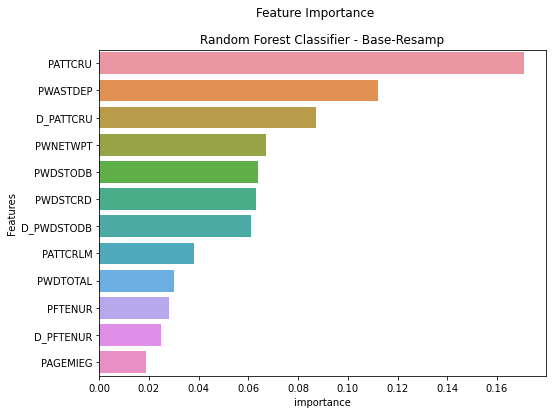

In [12]:
# Random Forest Classifier - BASE-RESAMP
rfc_b_rs = RandomForestClassifier(random_state=123, n_estimators=2000, max_depth=3).fit(base_resamp_train_X, base_resamp_train_y)
acc_rfc_b_rs=classificationSummary(base_resamp_valid_y, rfc_b_rs.predict(base_resamp_valid_X))
# AUROC
prob_y = rfc_b_rs.predict_proba(base_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_rfc_b_rs=roc_auc_score(base_resamp_valid_y,prob_y)
rfc_b_rs_acc_train=rfc_b_rs.score(base_resamp_train_X, base_resamp_train_y)
print("\nRandom Forest Classifier (Base-Resamp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_rfc_b_rs,rfc_b_rs_acc_train))
# Feature Importance
importance= rfc_b_rs.feature_importances_
df= pd.DataFrame({'feature': base_resamp_train_X.columns, 'importance': np.round(importance,3)})
# Feature Importance Plot
selected_imp=df.sort_values('importance', ascending=False)[:12]
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("Random Forest Classifier - Base-Resamp")

Confusion Matrix (Accuracy 0.5427)

       Prediction
Actual    0    1
     0 4009   66
     1 3661  414

AdaBoost Decision Tree Classifier (Base-Resamp) AUCROC: 0.6879
Valid Recall: 0.1110
Training Accuracy: 1.0000



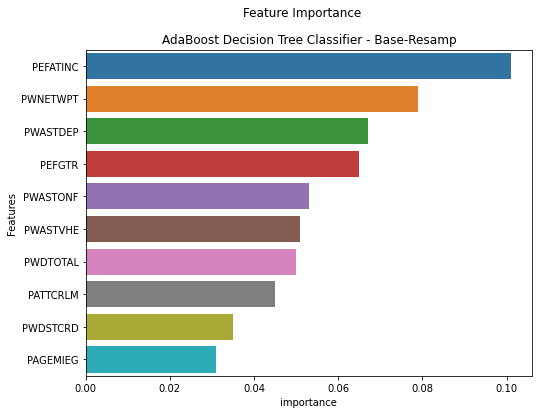

In [14]:
# AdaBoost Decision Tree Classifier - BASE-RESAMP
ada_b_rs=AdaBoostClassifier(DecisionTreeClassifier(random_state=123, max_depth=3),n_estimators=1000, random_state=1).fit(base_resamp_train_X, base_resamp_train_y)
acc_ada_b_rs=classificationSummary(base_resamp_valid_y, ada_b_rs.predict(base_resamp_valid_X))
# AUROC
prob_y = ada_b_rs.predict_proba(base_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_ada_b_rs=roc_auc_score(base_resamp_valid_y, prob_y)
ada_b_rs_acc_train=ada_b_rs.score(base_resamp_train_X, base_resamp_train_y)
ada_b_rs_valid_recall=(407/3668)
print("\nAdaBoost Decision Tree Classifier (Base-Resamp) AUCROC: {:.4f}\nValid Recall: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_ada_b_rs,ada_b_rs_valid_recall,ada_b_rs_acc_train))
# Feature Importance
importance= ada_b_rs.feature_importances_
df= pd.DataFrame({'feature': base_resamp_train_X.columns, 'importance': np.round(importance,3)})
selected_imp_ada_b_rs=df.sort_values('importance', ascending=False)[:10]
# Feature Importance Plot
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp_ada_b_rs['importance'], y = selected_imp_ada_b_rs['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("AdaBoost Decision Tree Classifier - Base-Resamp")
plt.show()

Confusion Matrix (Accuracy 0.6917)

       Prediction
Actual    0    1
     0 2832 1243
     1 1270 2805

Logistic Regression (Base-Resamp) AUCROC: 0.7503
Training Accuracy: 0.7189

Shap Value Feature Importance Explainer Plot



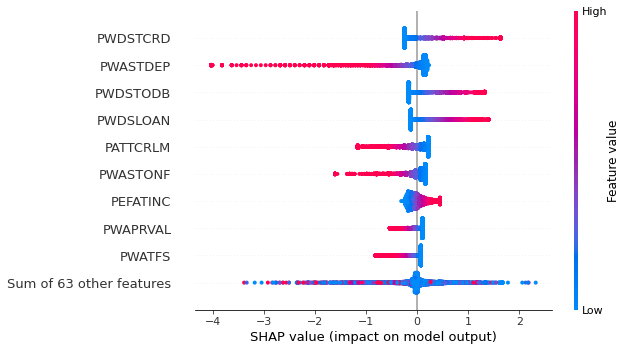

In [15]:
# Logistic Regression - BASE-Resamp
LogReg_b_rs = LogisticRegression(max_iter=1000000, solver='liblinear', class_weight='balanced').fit(base_resamp_train_X, base_resamp_train_y)
acc_log_b_rs=classificationSummary(base_resamp_valid_y, LogReg_b_rs.predict(base_resamp_valid_X))
# AUROC
prob_y = LogReg_b_rs.predict_proba(base_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_log_b_rs=roc_auc_score(base_resamp_valid_y, prob_y)
LogReg_b_rs_acc_train=LogReg_b_rs.score(base_resamp_train_X, base_resamp_train_y)
print("\nLogistic Regression (Base-Resamp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_log_b_rs,LogReg_b_rs_acc_train))
# Shap Explainer Plot
explainer_LogReg_b_rs = shap.Explainer(LogReg_b_rs, base_resamp_train_X, feature_names=base_resamp_train_X.columns.tolist())
shap_values_LogReg_b_rs = explainer_LogReg_b_rs(base_resamp_train_X)
print('Shap Value Feature Importance Explainer Plot\n')
shap.plots.beeswarm(shap_values_LogReg_b_rs)

*Sequential Feature Selection, Estimator: Logistic Regression, Data: Base-RESAMP*

Confusion Matrix (Accuracy 0.7189)

       Prediction
Actual    0    1
     0 2940 1135
     1 1156 2919

Evaluation of the 10 best variables:
    Logistic Regression (Base-Resamp) VALID AUCROC: 0.7858
    Training Accuracy: 0.7512
    Validation Accuracy: 0.7189



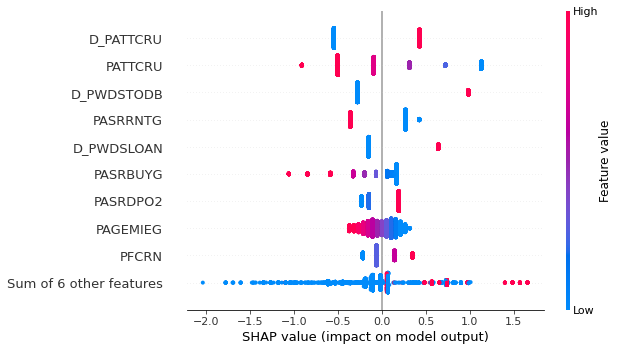



Optimization terminated successfully.
         Current function value: 0.536815
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                PATTSKP   No. Observations:                 8238
Model:                          Logit   Df Residuals:                     8223
Method:                           MLE   Df Model:                           14
Date:                Fri, 05 Aug 2022   Pseudo R-squ.:                  0.2255
Time:                        18:40:02   Log-Likelihood:                -4422.3
converged:                       True   LL-Null:                       -5710.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
IMP_PASR1MFA    -0.0002   3.28e-05     -5.131      0.000      -0.000      -0.000
PASRBUYG        -0.02

In [16]:
# Sequential Feature Selection: Forward
sfs_fwd_base_resamp = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(base_resamp_train_X, base_resamp_train_y)
# Creating a Results DataFrame
fwd_sel_base_resamp=pd.DataFrame.from_dict(sfs_fwd_base_resamp.get_metric_dict())
# Getting a list of the best 10 variables
fwd_sel_var_base_resamp=list(fwd_sel_base_resamp.loc['feature_names',15])
LogReg_b_rs = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_resamp_train_X[fwd_sel_var_base_resamp], base_resamp_train_y)
acc_log_b_rs=classificationSummary(base_resamp_valid_y, LogReg_b_rs.predict(base_resamp_valid_X[fwd_sel_var_base_resamp]))
# AUROC
prob_y = LogReg_b_rs.predict_proba(base_resamp_valid_X[fwd_sel_var_base_resamp])
prob_y = [p[1] for p in prob_y]
roc_log_b_rs=roc_auc_score(base_resamp_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_b_rs_acc_valid=LogReg_b_rs.score(base_resamp_valid_X[fwd_sel_var_base_resamp], base_resamp_valid_y)
LogReg_b_rs_acc_train=LogReg_b_rs.score(base_resamp_train_X[fwd_sel_var_base_resamp], base_resamp_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Resamp) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}\n".format(roc_log_b_rs,LogReg_b_rs_acc_train,LogReg_b_rs_acc_valid))
# 
explainer = shap.Explainer(LogReg_b_rs, base_resamp_train_X[fwd_sel_var_base_resamp], feature_names=base_resamp_train_X[fwd_sel_var_base_resamp].columns.tolist())
shap_values = explainer(base_resamp_train_X[fwd_sel_var_base_resamp])
shap.plots.beeswarm(shap_values)
# Stats
print('\n')
results=sm.Logit(base_resamp_train_y,base_resamp_train_X[fwd_sel_var_base_resamp]).fit()
print(results.summary())


In [17]:
# Sequential Feature Selection: Backward
#sfs_fwd_base_resamp = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
#                                                   class_weight='balanced'), 
#                                forward=False, verbose=2, k_features=10, scoring='roc_auc', n_jobs=-1).fit(base_resamp_train_X, base_resamp_train_y)
# Creating a Results DataFrame
#bwd_sel_base_resamp=pd.DataFrame.from_dict(sfs_fwd_base_resamp.get_metric_dict())
# Getting a list of the best 10 variables
#bwd_sel_var_base_resamp=list(bwd_sel_base_resamp.loc['feature_names',10])
#LogReg_b_rs = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_resamp_train_X[bwd_sel_var_base_resamp], base_resamp_train_y)
# AUROC
#prob_y = LogReg_b_rs.predict_proba(base_resamp_valid_X[bwd_sel_var_base_resamp])
#prob_y = [p[1] for p in prob_y]
#roc_log_b_rs=roc_auc_score(base_resamp_valid_y, prob_y)
# Valid and Training Accuracy
#LogReg_b_rs_acc_valid=LogReg_b_rs.score(base_resamp_train_X[bwd_sel_var_base_resamp], base_resamp_train_y)
#LogReg_b_rs_acc_train=LogReg_b_rs.score(base_resamp_train_X[bwd_sel_var_base_resamp], base_resamp_train_y)
#print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Resamp) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_b_rs,LogReg_b_rs_acc_train,LogReg_b_rs_acc_valid))

In [18]:
# Sequential Feature Selection: forward - stepwise
sfs_sw_base_resamp = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, floating=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(base_resamp_train_X, base_resamp_train_y)
# Creating a Results DataFrame
sw_sel_base_resamp=pd.DataFrame.from_dict(sfs_sw_base_resamp.get_metric_dict())
# Getting a list of the best 15 variables
sw_sel_var_base_resamp=list(sw_sel_base_resamp.loc['feature_names',15])
LogReg_b_rs = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_resamp_train_X[sw_sel_var_base_resamp], base_resamp_train_y)
acc_log_b_rs=classificationSummary(base_resamp_valid_y, LogReg_b_rs.predict(base_resamp_valid_X[sw_sel_var_base_resamp]))
# AUROC
prob_y = LogReg_b_rs.predict_proba(base_resamp_valid_X[sw_sel_var_base_resamp])
prob_y = [p[1] for p in prob_y]
roc_log_b_rs=roc_auc_score(base_resamp_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_b_rs_acc_valid=LogReg_b_rs.score(base_resamp_valid_X[sw_sel_var_base_resamp], base_resamp_valid_y)
LogReg_b_rs_acc_train=LogReg_b_rs.score(base_resamp_train_X[sw_sel_var_base_resamp], base_resamp_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Resamp) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_b_rs,LogReg_b_rs_acc_train,LogReg_b_rs_acc_valid))

Confusion Matrix (Accuracy 0.7140)

       Prediction
Actual    0    1
     0 2911 1164
     1 1167 2908

Evaluation of the 10 best variables:
    Logistic Regression (Base-Resamp) VALID AUCROC: 0.7846
    Training Accuracy: 0.7479
    Validation Accuracy: 0.7140


*Neural Network - Base-RESAMP*

Initial bias: 0.0
Weight for class 0: 1.00
Weight for class 1: 1.00

Restoring model weights from the end of the best epoch: 84.
Epoch 99: early stopping

Results:
    TN - FN: 3151 / 1439
    FP - TP: 924 / 2636

    Validation Accuracy: 0.7101
    Validation AUC_ROC: 0.796
    Validation Recall: 0.6469
    Precision: 0.7404



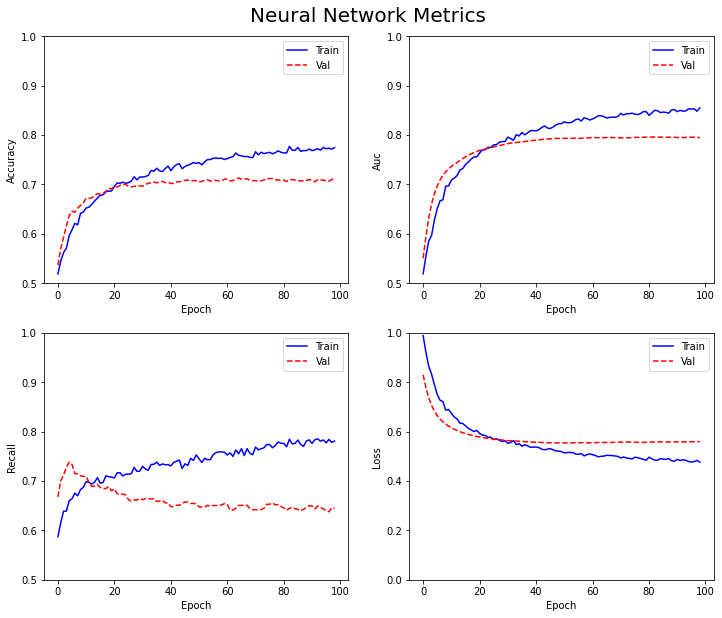

In [19]:
# Data Normalization for NN 
train_labels_b_rs = np.array(base_resamp_train_y)
bool_train_labels_b_rs = np.array(train_labels_b_rs != 0)
val_labels_b_rs = np.array(base_resamp_valid_y)
train_features_b_rs = np.array(base_resamp_train_X)
val_features_b_rs = np.array(base_resamp_valid_X)
# Normalizing data
scaler = StandardScaler()
train_features_b_rs = scaler.fit_transform(train_features_b_rs)
val_features_b_rs = scaler.transform(val_features_b_rs)
# Eliminating outliers
train_features_b_rs = np.clip(train_features_b_rs, -5, 5)
val_features_b_rs = np.clip(val_features_b_rs, -5, 5)
# Defining positive and negative target responses - will be used to set the weights and bias
pos_df_b_rs = pd.DataFrame(train_features_b_rs[ bool_train_labels_b_rs], columns=base_resamp_train_X.columns)
neg_df_b_rs = pd.DataFrame(train_features_b_rs[~bool_train_labels_b_rs], columns=base_resamp_train_X.columns)
neg_b_rs, pos_b_rs = np.bincount(base_resamp_train_y)
total_b_rs = neg_b_rs + pos_b_rs
# Defining the initial bias of the model - avoiding the model only 'learns' the bias during first epochs there's class 
initial_bias_b_rs = np.log([pos_b_rs/neg_b_rs])
print('Initial bias:', round(initial_bias_b_rs[0],2))
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0_b_rs = (1/neg_b_rs)*(total_b_rs/2.0)
weight_for_1_b_rs = (1/pos_b_rs)*(total_b_rs/2.0)
class_weight_b_rs = {0: weight_for_0_b_rs, 1: weight_for_1_b_rs}
print('Weight for class 0: {:.2f}'.format(weight_for_0_b_rs))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1_b_rs))

                                              # Function: Model - Initial Weights 
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),]
BATCH_SIZE = 2000
# Construct the Model
output_bias_b_rs = tf.keras.initializers.Constant(initial_bias_b_rs)
weights_b_rs = keras.Sequential([
    keras.layers.Dense(14, activation='relu',input_shape=(train_features_b_rs.shape[-1],)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias_b_rs),])
# Compile Model
weights_b_rs.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Evaluate
results_b_rs = weights_b_rs.evaluate(train_features_b_rs, train_labels_b_rs, batch_size=BATCH_SIZE, verbose=0)
initial_weights_b_rs = os.path.join(tempfile.mkdtemp(), 'initial_weights_b_rs')
weights_b_rs.save_weights(initial_weights_b_rs)

                                                     # Function: Model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
# Model
nn_b_rs = keras.Sequential([
    keras.layers.Dense(14, activation='relu',input_shape=(train_features_b_rs.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')])
# Compile Model
nn_b_rs.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Defining Additional Model Parameters
EPOCHS = 500
early_stopping_b_rs = tf.keras.callbacks.EarlyStopping(monitor='val_prc',verbose=1,patience=15,mode='max',restore_best_weights=True)
# Fit the model
nn_b_rs.load_weights(initial_weights_b_rs)
nn_b_rs_history = nn_b_rs.fit(
    train_features_b_rs,
    train_labels_b_rs,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping_b_rs],
    validation_data=(val_features_b_rs, val_labels_b_rs),
    class_weight=class_weight_b_rs)

#Evaluate the model
train_predictions_weighted_b_rs = nn_b_rs.predict(train_features_b_rs, batch_size=BATCH_SIZE)
test_predictions_weighted_b_rs = nn_b_rs.predict(train_features_b_rs, batch_size=BATCH_SIZE)

nn_b_rs_results = nn_b_rs.evaluate(val_features_b_rs, val_labels_b_rs, batch_size=BATCH_SIZE, verbose=0)
print('\nResults:\n    TN - FN: {:.0f} / {:.0f}\n    FP - TP: {:.0f} / {:.0f}\n\n    Validation Accuracy: {:.4}\n    Validation AUC_ROC: {:.4}\n    Validation Recall: {:.4}\n    Precision: {:.4}\n'.format(nn_b_rs_results[3],nn_b_rs_results[4],nn_b_rs_results[2],nn_b_rs_results[1],nn_b_rs_results[5],nn_b_rs_results[8],nn_b_rs_results[7],nn_b_rs_results[6]))

# Visuals
metrics = ['accuracy', 'auc','recall','loss']
fig, ax=plt.subplots(2,2, figsize=(12,10))
fig.text(x=0.5, y=0.90, s='Neural Network Metrics', fontsize=20, ha='center')
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(nn_b_rs_history.epoch, nn_b_rs_history.history[metric], color="blue", label='Train')
  plt.plot(nn_b_rs_history.epoch, nn_b_rs_history.history['val_'+metric],color="red", linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  if metric == 'recall':
    plt.ylim([0.5,1])
  elif metric == 'auc':
    plt.ylim([0.5,1])
  elif metric == 'accuracy':
    plt.ylim([0.5,1])
  else:
    plt.ylim([0,1])
  plt.legend();

## create SHAP explainer
def explainer_shap(model, X_names, X_instance, X_train=None, task="classification", top=10):
    ## create explainer
    ### machine learning
    if X_train is None:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_instance)
    ### deep learning
    else:
        explainer = shap.DeepExplainer(model, data=X_train[:100])
        shap_values = explainer.shap_values(X_instance.reshape(1,-1))[0].reshape(-1)
    ## plot
    ### classification
    if task == "classification":
        shap.decision_plot(explainer.expected_value, shap_values, link='logit', feature_order='importance',
                           features=X_instance, feature_names=X_names, feature_display_range=slice(-1,-top-1,-1))
    ### regression
    else:
        shap.waterfall_plot(explainer.expected_value[0], shap_values, 
                            features=X_instance, feature_names=X_names, max_display=top)

DATA AUGMENTATION WITH SMOTENC

In [21]:
# Defining X and y
base_train, base_valid = train_test_split(base_data, test_size=0.5, random_state=1)
base_train_X = base_train.drop(columns=['PATTSKP'])
base_train_y = base_train['PATTSKP']
base_valid_X = base_valid.drop(columns=['PATTSKP'])
base_valid_y = base_valid['PATTSKP']
# Turning Variables to int - SMOTENC was not able to synthesize new observations with these variables declared as categorical
v2=['D_PATTCRU','PATTPAYD','D2_PWNETWPT','D_PWATOTPT']
for i in data[v2]:
  data[i]=np.where(data[i]==0,'a',np.where(data[i]==1,'b','c'))
v3=['PATTSTIN','PATTRSH','PATTRSA','PASRDPO3','PASRDPO4','PASRRNTG']
for i in data[v3]:
  data[i]=np.where(data[i]==1,'a',np.where(data[i]==2,'b','c'))
data['PRETIRME']=np.where(data['PRETIRME']==1,'a',
                 np.where(data['PRETIRME']==2,'b',
                 np.where(data['PRETIRME']==6,'c','d')))
data['PEFMJSIF']=np.where(data['PEFMJSIF']==1,'a',
                 np.where(data['PEFMJSIF']==2,'b',
                 np.where(data['PEFMJSIF']==3,'c',
                 np.where(data['PEFMJSIF']==4,'d',
                 np.where(data['PEFMJSIF']==5,'e',
                 np.where(data['PEFMJSIF']==6,'f','g'))))))
data['PATTCRU']=np.where(data['PATTCRU']==0,'a',
                np.where(data['PATTCRU']==1,'b',
                np.where(data['PATTCRU']==2,'c',
                np.where(data['PATTCRU']==3,'d',
                np.where(data['PATTCRU']==4,'e','f')))))
# Running SMOTENC
base_train_X_smote_nc = SMOTENC(categorical_features=[base_train_X.dtypes=='category'], random_state=0)
base_syn_train_X,base_syn_train_y=base_train_X_smote_nc.fit_resample(base_train_X,base_train_y)
base_valid_X_smote_nc = SMOTENC(categorical_features=[base_valid_X.dtypes=='category'], random_state=0)
base_syn_valid_X,base_syn_valid_y=base_valid_X_smote_nc.fit_resample(base_valid_X,base_valid_y)
# Corroborating there are no null values after running SMOTENC
print('Null values in Feature dataframe:\n')
print(pd.DataFrame(base_syn_valid_X.isnull().sum()).sort_values(by=[0], ascending=False).head(3))
print('\nNull Values in the Target Variable:',base_syn_valid_y.isnull().sum())

print('Null values in Feature dataframe:\n')
print(pd.DataFrame(base_syn_train_X.isnull().sum()).sort_values(by=[0], ascending=False).head(3))
print('\nNull Values in the Target Variable:',base_syn_train_y.isnull().sum())
syn_data=pd.concat([base_syn_train_y,base_syn_valid_y])

Null values in Feature dataframe:

          0
PWASTMUI  0
PASRDPO1  0
PLFPDMEG  0

Null Values in the Target Variable: 0
Null values in Feature dataframe:

          0
PWASTMUI  0
PASRDPO1  0
PLFPDMEG  0

Null Values in the Target Variable: 0


In [22]:
# Full Classification Tree - BASE-SYN
fullClassTree_b_syn = DecisionTreeClassifier(random_state=1).fit(base_syn_train_X,base_syn_train_y)
acc_fct_b_syn=classificationSummary(base_syn_valid_y,fullClassTree_b_syn.predict(base_syn_valid_X))
# AUCROC
prob_y = fullClassTree_b_syn.predict_proba(base_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_fct_b_syn=roc_auc_score(base_syn_valid_y,prob_y)
fullClassTree_b_syn_acc_train=fullClassTree_b_syn.score(base_syn_train_X, base_syn_train_y)
print("\nAUCROC: {:.4f}\nFull Classification Tree Training Accuracy: {:.2f}".format(roc_fct_b_syn,fullClassTree_b_syn_acc_train))

Confusion Matrix (Accuracy 0.7904)

       Prediction
Actual    0    1
     0 3646  429
     1 1279 2796

AUCROC: 0.7904
Full Classification Tree Training Accuracy: 1.00


Confusion Matrix (Accuracy 0.8092)

       Prediction
Actual    0    1
     0 3099  976
     1  579 3496

Random Forest Classifier (Base-Syn) AUCROC: 0.8941
Training Accuracy: 0.8251



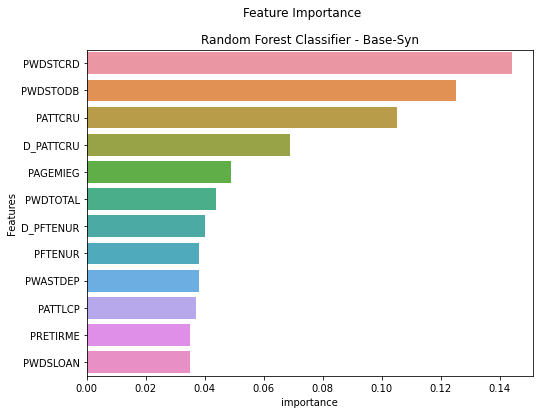

In [23]:
# Random Forest Classifier - BASE-SYN
rfc_b_syn = RandomForestClassifier(random_state=123, n_estimators=7500, max_depth=3).fit(base_syn_train_X, base_syn_train_y)
acc_rfc_b_syn=classificationSummary(base_syn_valid_y, rfc_b_syn.predict(base_syn_valid_X))
# AUROC
prob_y = rfc_b_syn.predict_proba(base_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_rfc_b_syn=roc_auc_score(base_syn_valid_y,prob_y)
rfc_b_syn_acc_train=rfc_b_syn.score(base_syn_train_X, base_syn_train_y)
print("\nRandom Forest Classifier (Base-Syn) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_rfc_b_syn,rfc_b_syn_acc_train))
# Feature Importance
importance= rfc_b_syn.feature_importances_
df= pd.DataFrame({'feature': base_syn_train_X.columns, 'importance': np.round(importance,3)})
# Feature Importance Plot
selected_imp=df.sort_values('importance', ascending=False)[:12]
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("Random Forest Classifier - Base-Syn")

Confusion Matrix (Accuracy 0.8823)

       Prediction
Actual    0    1
     0 3982   93
     1  866 3209

AdaBoost Decision Tree Classifier (Base-Syn) AUCROC: 0.9506
Training Accuracy: 1.0000



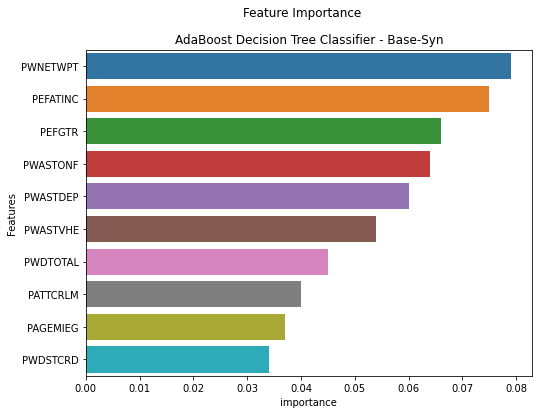

In [24]:
# AdaBoost Decision Tree Classifier - BASE-RESAMP
ada_b_syn=AdaBoostClassifier(DecisionTreeClassifier(random_state=123, max_depth=3),n_estimators=750, random_state=1).fit(base_syn_train_X, base_syn_train_y)
acc_ada_b_syn=classificationSummary(base_syn_valid_y, ada_b_syn.predict(base_syn_valid_X))
# AUROC
prob_y = ada_b_syn.predict_proba(base_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_ada_b_syn=roc_auc_score(base_syn_valid_y, prob_y)
ada_b_syn_acc_train=ada_b_syn.score(base_syn_train_X, base_syn_train_y)
print("\nAdaBoost Decision Tree Classifier (Base-Syn) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_ada_b_syn,ada_b_syn_acc_train))
# Feature Importance
importance= ada_b_syn.feature_importances_
df= pd.DataFrame({'feature': base_syn_train_X.columns, 'importance': np.round(importance,3)})
selected_imp=df.sort_values('importance', ascending=False)[:10]
# Feature Importance Plot
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("AdaBoost Decision Tree Classifier - Base-Syn")

Confusion Matrix (Accuracy 0.6902)

       Prediction
Actual    0    1
     0 2822 1253
     1 1272 2803

Logistic Regression (Base-Syn) AUCROC: 0.7578
Training Accuracy: 0.7289



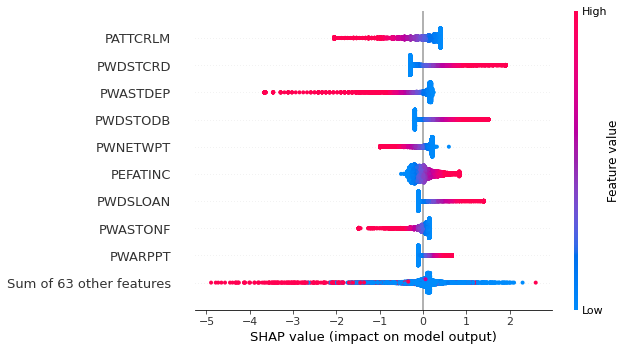

In [25]:
# Logistic Regression - BASE-Syn
LogReg_b_syn = LogisticRegression(max_iter=1000000, solver='liblinear', class_weight='balanced').fit(base_syn_train_X, base_syn_train_y)
acc_log_b_syn=classificationSummary(base_syn_valid_y, LogReg_b_syn.predict(base_syn_valid_X))
# AUROC
prob_y = LogReg_b_syn.predict_proba(base_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_log_b_syn=roc_auc_score(base_syn_valid_y, prob_y)
LogReg_b_syn_acc_train=LogReg_b_syn.score(base_syn_train_X, base_syn_train_y)
print("\nLogistic Regression (Base-Syn) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_log_b_syn,LogReg_b_syn_acc_train))

explainer = shap.Explainer(LogReg_b_syn, base_syn_train_X, feature_names=base_syn_train_X.columns.tolist())
shap_values = explainer(base_syn_train_X)
shap.plots.beeswarm(shap_values)

*Sequential Feature Selection, Estimator: Logistic Regression, Data: Base-RESAMP*

Confusion Matrix (Accuracy 0.7681)

       Prediction
Actual    0    1
     0 3139  936
     1  954 3121

Evaluation of the 10 best variables:
    Logistic Regression (Base-Syn) VALID AUCROC: 0.8450
    Training Accuracy: 0.7905
    Validation Accuracy: 0.7681



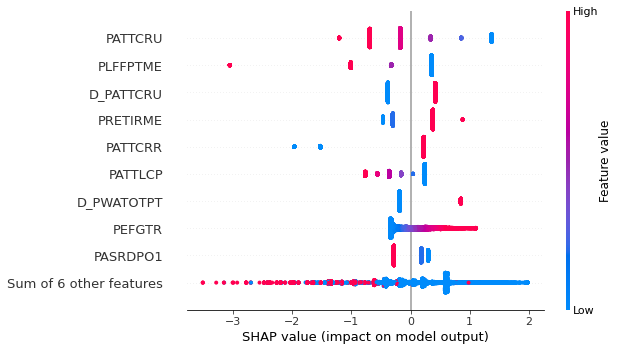

In [26]:
# Sequential Feature Selection: Forward
sfs_fwd_base_syn = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, floating=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(base_syn_train_X, base_syn_train_y)
# Creating a Results DataFrame
fwd_sel_base_syn=pd.DataFrame.from_dict(sfs_fwd_base_syn.get_metric_dict())
# Getting a list of the best 10 variables
fwd_sel_var_base_syn=list(fwd_sel_base_syn.loc['feature_names',15])
LogReg_b_syn = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
acc_log_b_syn=classificationSummary(base_syn_valid_y, LogReg_b_syn.predict(base_syn_valid_X[fwd_sel_var_base_syn]))
# AUROC
prob_y = LogReg_b_syn.predict_proba(base_syn_valid_X[fwd_sel_var_base_syn])
prob_y = [p[1] for p in prob_y]
roc_log_b_syn=roc_auc_score(base_syn_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_b_syn_acc_valid=LogReg_b_syn.score(base_syn_valid_X[fwd_sel_var_base_syn], base_syn_valid_y)
LogReg_b_syn_acc_train=LogReg_b_syn.score(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Syn) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}\n".format(roc_log_b_syn,LogReg_b_syn_acc_train,LogReg_b_syn_acc_valid))
explainer = shap.Explainer(LogReg_b_syn, base_syn_train_X[fwd_sel_var_base_syn], feature_names=base_syn_train_X[fwd_sel_var_base_syn].columns.tolist())
shap_values = explainer(base_syn_train_X[fwd_sel_var_base_syn])
shap.plots.beeswarm(shap_values)

In [27]:
# Sequential Feature Selection: Backward
#sfs_fwd_base_syn = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
#                                                   class_weight='balanced'), 
#                                forward=false, verbose=2, k_features=10, scoring='roc_auc', n_jobs=-1).fit(base_syn_train_X, base_syn_train_y)
# Creating a Results DataFrame
#fwd_sel_base_syn=pd.DataFrame.from_dict(sfs_fwd_base_syn.get_metric_dict())
# Getting a list of the best 10 variables
#fwd_sel_var_base_syn=list(fwd_sel_base_syn.loc['feature_names',10])
#LogReg_b_syn = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
# AUROC
#prob_y = LogReg_b_syn.predict_proba(base_syn_valid_X[fwd_sel_var_base_syn])
#prob_y = [p[1] for p in prob_y]
#roc_log_b_syn=roc_auc_score(base_syn_valid_y, prob_y)
# Valid and Training Accuracy
#LogReg_b_syn_acc_valid=LogReg_b_syn.score(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
#LogReg_b_syn_acc_train=LogReg_b_syn.score(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
#print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Syn) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_b_syn,LogReg_b_syn_acc_train,LogReg_b_syn_acc_valid))

In [28]:
# Sequential Feature Selection: Forward
sfs_fwd_base_syn = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, floating=False, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(base_syn_train_X, base_syn_train_y)
# Creating a Results DataFrame
fwd_sel_base_syn=pd.DataFrame.from_dict(sfs_fwd_base_syn.get_metric_dict())
# Getting a list of the best 10 variables
fwd_sel_var_base_syn=list(fwd_sel_base_syn.loc['feature_names',15])
LogReg_b_syn = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
acc_log_b_syn=classificationSummary(base_syn_valid_y, LogReg_b_syn.predict(base_syn_valid_X[fwd_sel_var_base_syn]))
# AUROC
prob_y = LogReg_b_syn.predict_proba(base_syn_valid_X[fwd_sel_var_base_syn])
prob_y = [p[1] for p in prob_y]
roc_log_b_syn=roc_auc_score(base_syn_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_b_syn_acc_valid=LogReg_b_syn.score(base_syn_valid_X[fwd_sel_var_base_syn], base_syn_valid_y)
LogReg_b_syn_acc_train=LogReg_b_syn.score(base_syn_train_X[fwd_sel_var_base_syn], base_syn_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Syn) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_b_syn,LogReg_b_syn_acc_train,LogReg_b_syn_acc_valid))

Confusion Matrix (Accuracy 0.7675)

       Prediction
Actual    0    1
     0 3035 1040
     1  855 3220

Evaluation of the 10 best variables:
    Logistic Regression (Base-Syn) VALID AUCROC: 0.8425
    Training Accuracy: 0.7816
    Validation Accuracy: 0.7675


*NN - Base-SYN*

Initial bias: 0.0
Weight for class 0: 1.00
Weight for class 1: 1.00

Restoring model weights from the end of the best epoch: 263.
Epoch 278: early stopping

Results:
    TN - FN: 3552 / 1152
    FP - TP: 523 / 2923

    Validation Accuracy: 0.7945
    Validation AUC_ROC: 0.8988
    Validation Recall: 0.7173
    Precision: 0.8482



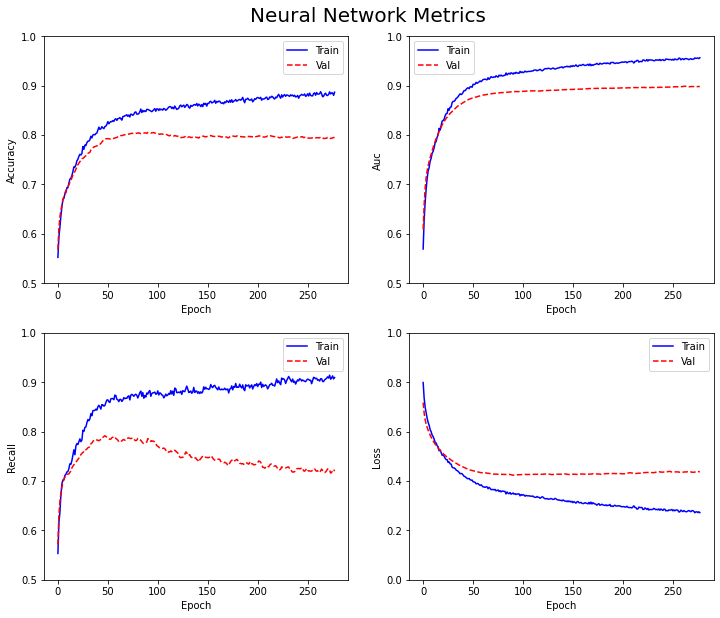

In [29]:
# Data Normalization for NN 
train_labels_b_syn = np.array(base_syn_train_y)
bool_train_labels_b_syn = train_labels_b_syn != 0
val_labels_b_syn = np.array(base_syn_valid_y)
train_features_b_syn = np.array(base_syn_train_X)
val_features_b_syn = np.array(base_syn_valid_X)
# Normalizing data
scaler = StandardScaler()
train_features_b_syn = scaler.fit_transform(train_features_b_syn)
val_features_b_syn = scaler.transform(val_features_b_syn)
# Eliminating outliers
train_features_b_syn = np.clip(train_features_b_syn, -5, 5)
val_features_b_syn = np.clip(val_features_b_syn, -5, 5)
# Defining positive and negative target responses - will be used to set the weights and bias
pos_df_b_syn = pd.DataFrame(train_features_b_syn[ bool_train_labels_b_syn], columns=base_syn_train_X.columns) #train_df_b_syn
neg_df_b_syn = pd.DataFrame(train_features_b_syn[~bool_train_labels_b_syn], columns=base_syn_train_X.columns)
neg_b_syn, pos_b_syn = np.bincount(syn_data)
total_b_syn = neg_b_syn + pos_b_syn
# Defining the initial bias of the model - avoiding the model only 'learns' the bias during first epochs there's class 
initial_bias_b_syn = np.log([pos_b_syn/neg_b_syn])
print('Initial bias:', round(initial_bias_b_syn[0],2))
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0_b_syn = (1/neg_b_syn)*(total_b_syn/2.0)
weight_for_1_b_syn = (1/pos_b_syn)*(total_b_syn/2.0)
class_weight_b_syn = {0: weight_for_0_b_syn, 1: weight_for_1_b_syn}
print('Weight for class 0: {:.2f}'.format(weight_for_0_b_syn))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1_b_syn))


                                              # Function: Model - Initial Weights 
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),]
BATCH_SIZE = 2000
# Construct the Model
output_bias_b_syn = tf.keras.initializers.Constant(initial_bias_b_syn)
weights_b_syn = keras.Sequential([
    keras.layers.Dense(10, activation='relu',input_shape=(train_features_b_syn.shape[-1],)),
    keras.layers.Dropout(0.50),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias_b_syn),])
# Compile Model
weights_b_syn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Evaluate
results_b_syn = weights_b_syn.evaluate(train_features_b_syn, train_labels_b_syn, batch_size=BATCH_SIZE, verbose=0)
initial_weights_b_syn = os.path.join(tempfile.mkdtemp(), 'initial_weights_b_syn')
weights_b_syn.save_weights(initial_weights_b_syn)

                                                     # Function: Model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
# Model
nn_b_syn = keras.Sequential([
    keras.layers.Dense(10, activation='relu',input_shape=(train_features_b_syn.shape[-1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])
# Compile Model
nn_b_syn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Defining Additional Model Parameters
EPOCHS = 600
early_stopping_b_syn = tf.keras.callbacks.EarlyStopping(monitor='val_prc',verbose=1,patience=15,mode='max',restore_best_weights=True)
# Fit the model
nn_b_syn.load_weights(initial_weights_b_syn)
nn_b_syn_history = nn_b_syn.fit(
    train_features_b_syn,
    train_labels_b_syn,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping_b_syn],
    validation_data=(val_features_b_syn, val_labels_b_syn),
    class_weight=class_weight_b_syn)

#Evaluate the model
train_predictions_weighted_b_syn = nn_b_syn.predict(train_features_b_syn, batch_size=BATCH_SIZE)
test_predictions_weighted_b_syn = nn_b_syn.predict(val_features_b_syn, batch_size=BATCH_SIZE)

nn_b_syn_results = nn_b_syn.evaluate(val_features_b_syn, val_labels_b_syn, batch_size=BATCH_SIZE, verbose=0)
print('\nResults:\n    TN - FN: {:.0f} / {:.0f}\n    FP - TP: {:.0f} / {:.0f}\n\n    Validation Accuracy: {:.4}\n    Validation AUC_ROC: {:.4}\n    Validation Recall: {:.4}\n    Precision: {:.4}\n'.format(nn_b_syn_results[3],nn_b_syn_results[4],nn_b_syn_results[2],nn_b_syn_results[1],nn_b_syn_results[5],nn_b_syn_results[8],nn_b_syn_results[7],nn_b_syn_results[6]))

# Visuals
metrics = ['accuracy', 'auc','recall','loss']
fig, ax=plt.subplots(2,2, figsize=(12,10))
fig.text(x=0.5, y=0.90, s='Neural Network Metrics', fontsize=20, ha='center')
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(nn_b_syn_history.epoch, nn_b_syn_history.history[metric], color="blue", label='Train')
  plt.plot(nn_b_syn_history.epoch, nn_b_syn_history.history['val_'+metric],color="red", linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  if metric == 'recall':
    plt.ylim([0.5,1])
  elif metric == 'auc':
    plt.ylim([0.5,1])
  elif metric == 'accuracy':
    plt.ylim([0.5,1])
  else:
    plt.ylim([0,1])
  plt.legend();

## TRANS DATA (VARIABLES WITH TRANSFORMATIONS)

**DATA WITH CLASS IMBALANCE - NO DATA AUGMENTATION = no_samp**

In [30]:
# Data Partitioning and Variable Declaration
trans_no_samp_X = trans_data.drop(columns=['PATTSKP'])
trans_no_samp_y = trans_data['PATTSKP']
trans_no_samp_train_X, trans_no_samp_valid_X, trans_no_samp_train_y, trans_no_samp_valid_y = train_test_split(trans_no_samp_X,trans_no_samp_y, test_size=0.5, random_state=1)
print('PATTSKP - Value Counts\n    Yes: {}\n    No: {}'.format(data.PATTSKP.value_counts()[1],data.PATTSKP.value_counts()[0]))

PATTSKP - Value Counts
    Yes: 646
    No: 8194


In [31]:
# Full Classification Tree - TRANS-NO_SAMP
fullClassTree_t_ns = DecisionTreeClassifier(random_state=1).fit(trans_no_samp_train_X,trans_no_samp_train_y)
acc_fct_t_ns=classificationSummary(trans_no_samp_valid_y,fullClassTree_t_ns.predict(trans_no_samp_valid_X))
# AUCROC
prob_y = fullClassTree_t_ns.predict_proba(trans_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_fct_t_ns=roc_auc_score(trans_no_samp_valid_y,prob_y)
fullClassTree_t_ns_acc_train=fullClassTree_t_ns.score(trans_no_samp_train_X, trans_no_samp_train_y)
print("\nAUCROC: {:.4f}\nTraining Accuracy: {:.2f}".format(roc_fct_t_ns,fullClassTree_t_ns_acc_train))

Confusion Matrix (Accuracy 0.8719)

       Prediction
Actual    0    1
     0 3788  287
     1  279   66

AUCROC: 0.5604
Training Accuracy: 1.00


Confusion Matrix (Accuracy 0.9219)

       Prediction
Actual    0    1
     0 4075    0
     1  345    0

Random Forest Classifier (Trans-No_Samp) AUCROC: 0.7962
Training Accuracy: 0.9319



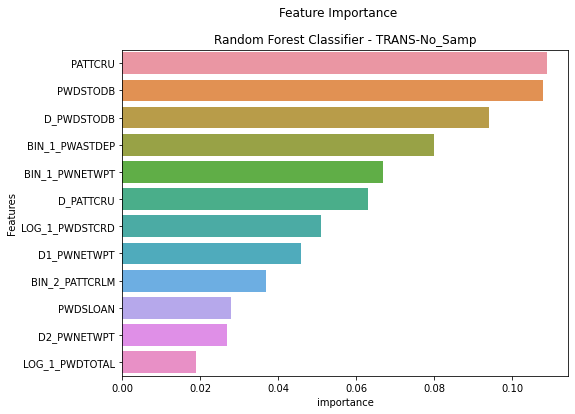

In [32]:
# Random Forest Classifier - TRANS-NO_SAMP
rfc_t_ns = RandomForestClassifier(random_state=123, n_estimators=750, max_depth=3).fit(trans_no_samp_train_X, trans_no_samp_train_y)
acc_rfc_t_ns=classificationSummary(trans_no_samp_valid_y, rfc_t_ns.predict(trans_no_samp_valid_X))
# AUROC
prob_y = rfc_t_ns.predict_proba(trans_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_rfc_t_ns=roc_auc_score(trans_no_samp_valid_y,prob_y)
rfc_t_ns_acc_train=rfc_t_ns.score(trans_no_samp_train_X, trans_no_samp_train_y)
print("\nRandom Forest Classifier (Trans-No_Samp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_rfc_t_ns,rfc_t_ns_acc_train))
# Feature Importance
importance= rfc_t_ns.feature_importances_
df= pd.DataFrame({'feature': trans_no_samp_train_X.columns, 'importance': np.round(importance,3)})
# Feature Importance Plot
selected_imp=df.sort_values('importance', ascending=False)[:12]
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("Random Forest Classifier - TRANS-No_Samp")

Confusion Matrix (Accuracy 0.9158)

       Prediction
Actual    0    1
     0 4022   53
     1  319   26

AdaBoost Decision Tree Classifier (Trans-No_Samp) AUCROC: 0.7081
Training Accuracy: 1.0000



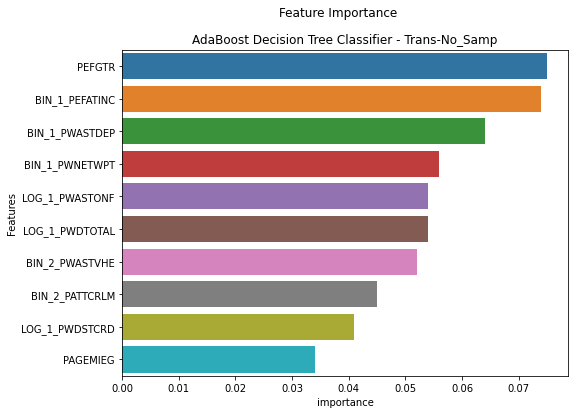

In [33]:
# AdaBoost Decision Tree Classifier - TRANS-NO_SAMP
ada_t_ns=AdaBoostClassifier(DecisionTreeClassifier(random_state=123, max_depth=3),n_estimators=750, random_state=1).fit(trans_no_samp_train_X, trans_no_samp_train_y)
acc_ada_t_ns=classificationSummary(trans_no_samp_valid_y, ada_t_ns.predict(trans_no_samp_valid_X))
# AUROC
prob_y = ada_t_ns.predict_proba(trans_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_ada_t_ns=roc_auc_score(trans_no_samp_valid_y, prob_y)
ada_t_ns_acc_train=ada_t_ns.score(trans_no_samp_train_X, trans_no_samp_train_y)
print("\nAdaBoost Decision Tree Classifier (Trans-No_Samp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_ada_t_ns,ada_t_ns_acc_train))
# Feature Importance
importance= ada_t_ns.feature_importances_
df= pd.DataFrame({'feature': trans_no_samp_train_X.columns, 'importance': np.round(importance,3)})
selected_imp=df.sort_values('importance', ascending=False)[:10]
# Feature Importance Plot
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("AdaBoost Decision Tree Classifier - Trans-No_Samp")

Confusion Matrix (Accuracy 0.7219)

       Prediction
Actual    0    1
     0 2940 1135
     1   94  251

Logistic Regression (Trans-No_Samp) AUCROC: 0.8060
Training Accuracy: 0.7357



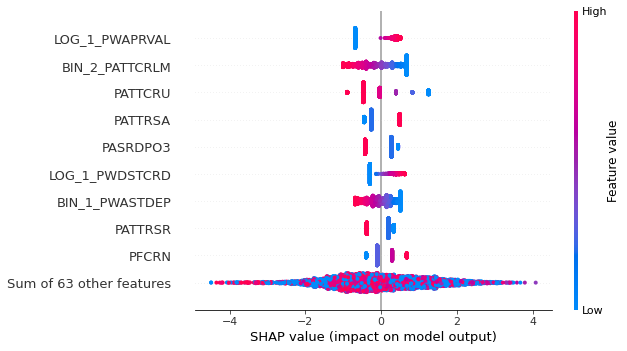

In [34]:
# Logistic Regression - TRANS-No_Samp
LogReg_t_ns = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_no_samp_train_X, trans_no_samp_train_y)
acc_log_t_ns=classificationSummary(trans_no_samp_valid_y, LogReg_t_ns.predict(trans_no_samp_valid_X))
# AUROC
prob_y = LogReg_t_ns.predict_proba(trans_no_samp_valid_X)
prob_y = [p[1] for p in prob_y]
ROC_LOG_T_NS=roc_auc_score(trans_no_samp_valid_y, prob_y)
LogRegACC_train=LogReg_t_ns.score(trans_no_samp_train_X, trans_no_samp_train_y)
print("\nLogistic Regression (Trans-No_Samp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(ROC_LOG_T_NS,LogRegACC_train))

explainer = shap.Explainer(LogReg_t_ns, trans_no_samp_train_X, feature_names=trans_no_samp_train_X.columns.tolist())
shap_values = explainer(trans_no_samp_train_X)
shap.plots.beeswarm(shap_values)

*Neural Network - Base-NO_SAMP*

Initial bias: -2.54
Weight for class 0: 0.54
Weight for class 1: 6.84



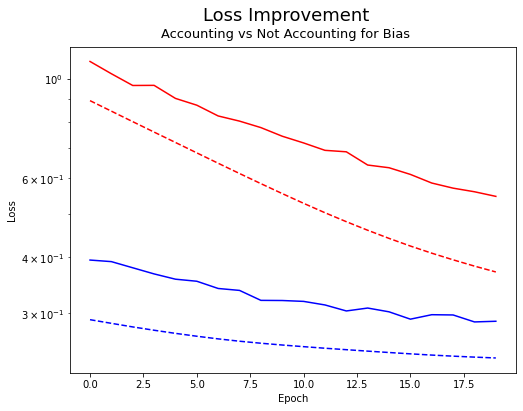



Restoring model weights from the end of the best epoch: 90.
Epoch 105: early stopping


Results:
    TN - FN: 3335 / 108
    FP - TP: 757 / 220

    Validation Accuracy: 0.8043
    Validation AUC_ROC: 0.8219
    Validation Recall: 0.6707
    Precision: 0.2252



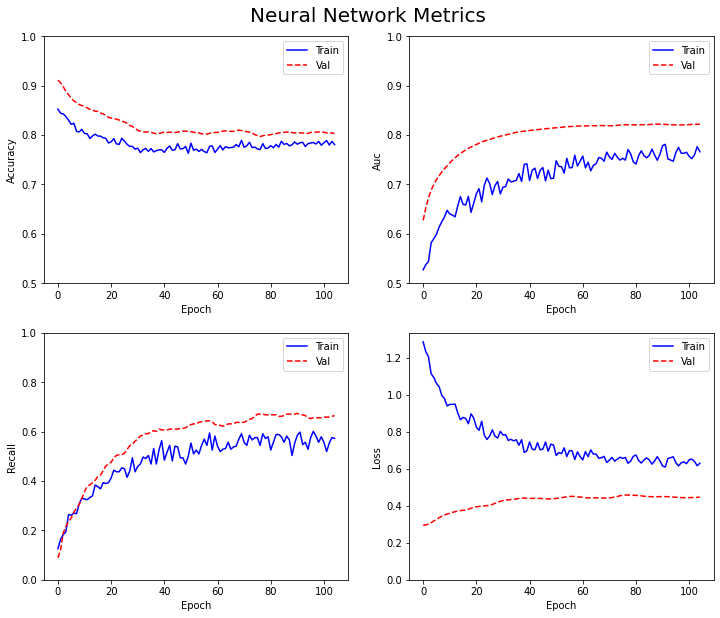

In [35]:
# Data Normalization for NN 
# Splitting data with no previous transformations into train-test-validation
train_df_t_ns, val_df_t_ns = train_test_split(trans_data, test_size=0.5)
# Create np arrays of labels and features.
train_labels_t_ns = np.array(train_df_t_ns.pop('PATTSKP'))
bool_train_labels_t_ns = train_labels_t_ns != 0
val_labels_t_ns = np.array(val_df_t_ns.pop('PATTSKP'))
train_features_t_ns = np.array(train_df_t_ns)
val_features_t_ns = np.array(val_df_t_ns)
# Normalizing data
scaler = StandardScaler()
train_features_t_ns = scaler.fit_transform(train_features_t_ns)
val_features_t_ns = scaler.transform(val_features_t_ns)
# Eliminating outliers
train_features_t_ns = np.clip(train_features_t_ns, -5, 5)
val_features_t_ns = np.clip(val_features_t_ns, -5, 5)
# Defining positive and negative target responses - will be used to set the weights and bias
pos_df_t_ns = pd.DataFrame(train_features_t_ns[ bool_train_labels_t_ns], columns=train_df_t_ns.columns)
neg_df_t_ns = pd.DataFrame(train_features_t_ns[~bool_train_labels_t_ns], columns=train_df_t_ns.columns)
neg_t_ns, pos_t_ns = np.bincount(data['PATTSKP'])
total_t_ns = neg_t_ns + pos_t_ns
# Defining the initial bias of the model - avoiding the model only 'learns' the bias during first epochs there's class 
initial_bias_t_ns = np.log([pos_t_ns/neg_t_ns])
print('Initial bias:', round(initial_bias_t_ns[0],2))
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0_t_ns = (1/neg_t_ns)*(total_t_ns/2.0)
weight_for_1_t_ns = (1/pos_t_ns)*(total_t_ns/2.0)
class_weight_t_ns = {0: weight_for_0_t_ns, 1: weight_for_1_t_ns}
print('Weight for class 0: {:.2f}'.format(weight_for_0_t_ns))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1_t_ns))

                                              # Function: Model - Initial Weights 
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),]
BATCH_SIZE=2000
# Construct the Model
output_bias_t_ns = tf.keras.initializers.Constant(initial_bias_t_ns)
weights_t_ns = keras.Sequential([
    keras.layers.Dense(12, activation='relu',input_shape=(train_features_t_ns.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias_t_ns),])
# Compile Model
weights_t_ns.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Evaluate
results_t_ns = weights_t_ns.evaluate(train_features_t_ns, train_labels_t_ns,batch_size=2000,verbose=0)
initial_weights_t_ns = os.path.join(tempfile.mkdtemp(), 'initial_weights_t_ns')
weights_t_ns.save_weights(initial_weights_t_ns)
# Visualizations of Loss Reduction for Model Accounting for Bias 
# Zero-bias model (Naive Initialization)
weights_t_ns.load_weights(initial_weights_t_ns)
weights_t_ns.layers[-1].bias.assign([0.0])
zero_bias_history_t = weights_t_ns.fit(train_features_t_ns,train_labels_t_ns,batch_size=BATCH_SIZE,epochs=20,validation_data=(val_features_t_ns, val_labels_t_ns), verbose=0)
# Pre-trained model
weights_t_ns.load_weights(initial_weights_t_ns)
accounts_bias_history_t = weights_t_ns.fit(train_features_t_ns,train_labels_t_ns,batch_size=BATCH_SIZE,epochs=20,validation_data=(val_features_t_ns, val_labels_t_ns), verbose=0)
# Visualization
loss, ax=plt.subplots(figsize=(8,6))
ax1=plt.semilogy(accounts_bias_history_t.epoch, accounts_bias_history_t.history['loss'],color='blue', )
ax1=plt.semilogy(accounts_bias_history_t.epoch, accounts_bias_history_t.history['val_loss'],color='blue', label='Val ', linestyle="--")
ax1=plt.semilogy(zero_bias_history_t.epoch, zero_bias_history_t.history['loss'],color='red', )
ax1=plt.semilogy(zero_bias_history_t.epoch, zero_bias_history_t.history['val_loss'],color='red', label='Val ', linestyle="--")
loss.text(x=0.5, y=0.94, s='Loss Improvement', fontsize=18, ha='center')
loss.text(x=0.5, y=0.90, s='Accounting vs Not Accounting for Bias', fontsize=13, ha='center')
ax1=plt.xlabel('Epoch')
ax1=plt.ylabel('Loss')
plt.show()
print('\n')
                                                        # Function: Model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
# Construct the Model
nn_t_ns = keras.Sequential([
    keras.layers.Dense(12, activation='relu',input_shape=(train_features_t_ns.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')])
# Compile Model
nn_t_ns.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Defining Additional Parameters
EPOCHS = 500
BATCH_SIZE = 2000
early_stopping_t_ns = tf.keras.callbacks.EarlyStopping(monitor='val_prc',verbose=1,patience=15,mode='max',restore_best_weights=True)
# Fit the model
nn_t_ns.load_weights(initial_weights_t_ns)
nn_t_ns_history = nn_t_ns.fit(
    train_features_t_ns,
    train_labels_t_ns,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping_t_ns],
    validation_data=(val_features_t_ns, val_labels_t_ns),
    class_weight=class_weight_t_ns)

# Evaluate the model
train_predictions_weighted_t_ns = nn_t_ns.predict(train_features_t_ns, batch_size=BATCH_SIZE)
valid_predictions_weighted_t_ns = nn_t_ns.predict(val_features_t_ns, batch_size=BATCH_SIZE)

nn_t_ns_results = nn_t_ns.evaluate(val_features_t_ns, val_labels_t_ns, batch_size=BATCH_SIZE, verbose=0)
print('\n\nResults:\n    TN - FN: {:.0f} / {:.0f}\n    FP - TP: {:.0f} / {:.0f}\n\n    Validation Accuracy: {:.4}\n    Validation AUC_ROC: {:.4}\n    Validation Recall: {:.4}\n    Precision: {:.4}\n'.format(nn_t_ns_results[3],nn_t_ns_results[4],nn_t_ns_results[2],nn_t_ns_results[1],nn_t_ns_results[5],nn_t_ns_results[8],nn_t_ns_results[7],nn_t_ns_results[6]))

# Visuals
metrics = ['accuracy', 'auc','recall','loss']
fig, ax=plt.subplots(2,2, figsize=(12,10))
fig.text(x=0.5, y=0.90, s='Neural Network Metrics', fontsize=20, ha='center')
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(nn_t_ns_history.epoch, nn_t_ns_history.history[metric], color="blue", label='Train')
  plt.plot(nn_t_ns_history.epoch, nn_t_ns_history.history['val_'+metric],color="red", linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.5,1])
  elif metric == 'accuracy':
    plt.ylim([0.5,1])
  else:
    plt.ylim([0,1])
  plt.legend();

**DATA AUGMENTATION WITH SIMPLE RESAMPLING (RESAMP)**

In [37]:
# Train-test split data
trans_resamp_train, trans_resamp_valid = train_test_split(trans_data, test_size=0.5, random_state=1)
# Identify positives and negatives
data_major_train = trans_resamp_train[data.PATTSKP==0]
data_minor_train = trans_resamp_train[data.PATTSKP==1]
data_major_valid = trans_resamp_valid[data.PATTSKP==0]
data_minor_valid = trans_resamp_valid[data.PATTSKP==1]
# Upsampling the minor class (positives)
data_minor_train_resampled = resample(data_minor_train, replace=True, n_samples=4119, random_state=1)
data_minor_valid_resampled = resample(data_minor_valid, replace=True, n_samples=4075, random_state=1)
# Merging the minor and major class datasets
data_resampled_train = pd.concat([data_major_train, data_minor_train_resampled])
data_resampled_valid = pd.concat([data_major_valid, data_minor_valid_resampled])
# Value counts
print('Train - Value Counts PATTSKP:\n    Negatives: {}\n    Positives: {}\n'.format(data_resampled_valid.PATTSKP.value_counts()[0],data_resampled_valid.PATTSKP.value_counts()[1]))
print('Valid - Value Counts PATTSKP:\n    Negatives: {}\n    Positives: {}\n'.format(data_resampled_train.PATTSKP.value_counts()[0],data_resampled_train.PATTSKP.value_counts()[1]))
# Defining labels and features
trans_resamp_valid_y = data_resampled_valid.PATTSKP
trans_resamp_valid_X = data_resampled_valid.drop(columns=['PATTSKP'], axis=1)
trans_resamp_train_y = data_resampled_train.PATTSKP
trans_resamp_train_X = data_resampled_train.drop(columns=['PATTSKP'], axis=1)

Train - Value Counts PATTSKP:
    Negatives: 4075
    Positives: 4075

Valid - Value Counts PATTSKP:
    Negatives: 4119
    Positives: 4119



In [38]:
# Full Classification Tree - TRANS-RESAMP
fullClassTree_t_rs = DecisionTreeClassifier(random_state=1).fit(trans_resamp_train_X,trans_resamp_train_y)
acc_fct_t_rs=classificationSummary(trans_resamp_valid_y,fullClassTree_t_rs.predict(trans_resamp_valid_X))
# AUCROC
prob_y = fullClassTree_t_rs.predict_proba(trans_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_fct_t_rs=roc_auc_score(trans_resamp_valid_y,prob_y)
fullClassTree_t_rs_acc_train=fullClassTree_t_rs.score(trans_resamp_train_X, trans_resamp_train_y)
print("\nAUCROC: {:.4f}\nFull Classification Tree Training Accuracy: {:.2f}".format(roc_fct_t_rs,fullClassTree_t_rs_acc_train))

Confusion Matrix (Accuracy 0.5433)

       Prediction
Actual    0    1
     0 3835  240
     1 3482  593

AUCROC: 0.5433
Full Classification Tree Training Accuracy: 1.00


Confusion Matrix (Accuracy 0.7207)

       Prediction
Actual    0    1
     0 2772 1303
     1  973 3102

Random Forest Classifier (Trans-Resamp) AUCROC: 0.7879
Training Accuracy: 0.7521



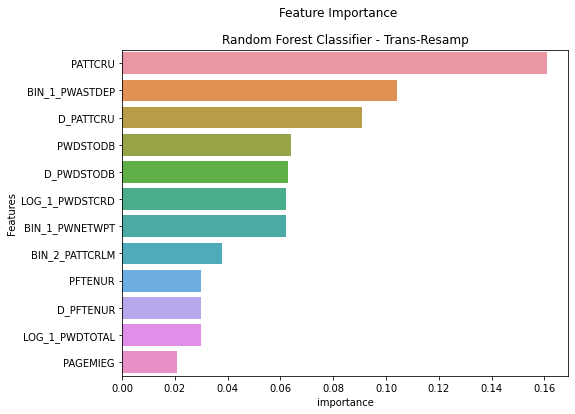

In [39]:
# Random Forest Classifier - TRANS-RESAMP
rfc_t_rs = RandomForestClassifier(random_state=123, n_estimators=750, max_depth=3).fit(trans_resamp_train_X, trans_resamp_train_y)
acc_rfc_t_rs=classificationSummary(trans_resamp_valid_y, rfc_t_rs.predict(trans_resamp_valid_X))
# AUROC
prob_y = rfc_t_rs.predict_proba(trans_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_rfc_t_rs=roc_auc_score(trans_resamp_valid_y,prob_y)
rfc_t_rs_acc_train=rfc_t_rs.score(trans_resamp_train_X, trans_resamp_train_y)
print("\nRandom Forest Classifier (Trans-Resamp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_rfc_t_rs,rfc_t_rs_acc_train))
# Feature Importance
importance= rfc_t_rs.feature_importances_
df= pd.DataFrame({'feature': trans_resamp_train_X.columns, 'importance': np.round(importance,3)})
# Feature Importance Plot
selected_imp=df.sort_values('importance', ascending=False)[:12]
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("Random Forest Classifier - Trans-Resamp")

Confusion Matrix (Accuracy 0.5315)

       Prediction
Actual    0    1
     0 3999   76
     1 3742  333

AdaBoost Decision Tree Classifier (Trans-Resamp) AUCROC: 0.6851
Training Accuracy: 1.0000



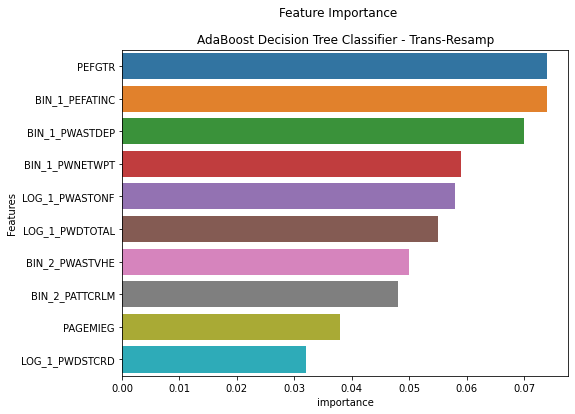

In [40]:
# AdaBoost Decision Tree Classifier - TRANS-RESAMP
ada_t_rs=AdaBoostClassifier(DecisionTreeClassifier(random_state=123, max_depth=3),n_estimators=750, random_state=1).fit(trans_resamp_train_X, trans_resamp_train_y)
acc_ada_t_rs=classificationSummary(trans_resamp_valid_y, ada_t_rs.predict(trans_resamp_valid_X))
# AUROC
prob_y = ada_t_rs.predict_proba(trans_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_ada_t_rs=roc_auc_score(trans_resamp_valid_y, prob_y)
ada_t_rs_acc_train=ada_t_rs.score(trans_resamp_train_X, trans_resamp_train_y)
print("\nAdaBoost Decision Tree Classifier (Trans-Resamp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_ada_t_rs,ada_t_rs_acc_train))
# Feature Importance
importance= ada_t_rs.feature_importances_
df= pd.DataFrame({'feature': trans_resamp_train_X.columns, 'importance': np.round(importance,3)})
selected_imp=df.sort_values('importance', ascending=False)[:10]
# Feature Importance Plot
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("AdaBoost Decision Tree Classifier - Trans-Resamp")

Confusion Matrix (Accuracy 0.7308)

       Prediction
Actual    0    1
     0 2947 1128
     1 1066 3009

Logistic Regression (Trans-Resamp) AUCROC: 0.7997
Training Accuracy: 0.7597



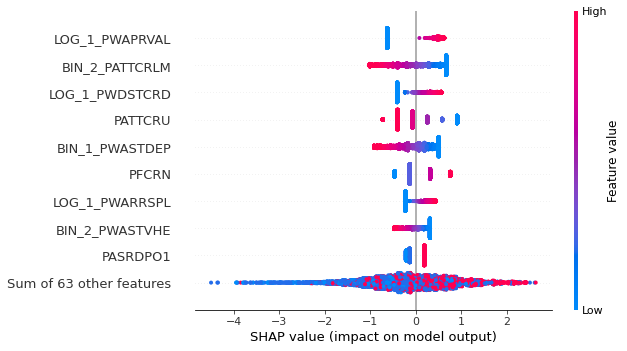

In [41]:
# Logistic Regression - TRANS-Resamp
LogReg_t_rs = LogisticRegression(max_iter=1000000, solver='liblinear', class_weight='balanced').fit(trans_resamp_train_X, trans_resamp_train_y)
acc_log_t_rs=classificationSummary(trans_resamp_valid_y, LogReg_t_rs.predict(trans_resamp_valid_X))
# AUROC
prob_y = LogReg_t_rs.predict_proba(trans_resamp_valid_X)
prob_y = [p[1] for p in prob_y]
roc_log_t_rs=roc_auc_score(trans_resamp_valid_y, prob_y)
LogReg_t_rs_acc_train=LogReg_t_rs.score(trans_resamp_train_X, trans_resamp_train_y)
print("\nLogistic Regression (Trans-Resamp) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_log_t_rs,LogReg_t_rs_acc_train))

explainer = shap.Explainer(LogReg_t_rs, trans_resamp_train_X, feature_names=trans_resamp_train_X.columns.tolist())
shap_values = explainer(trans_resamp_train_X)
shap.plots.beeswarm(shap_values)

*Sequential Feature Selection, Estimator: Logistic Regression, Data: Base-RESAMP*

Confusion Matrix (Accuracy 0.7347)

       Prediction
Actual    0    1
     0 3012 1063
     1 1099 2976

Evaluation of the 10 best variables:
    Logistic Regression (Trans-Resamp) VALID AUCROC: 0.8050
    Training Accuracy: 0.7573
    Validation Accuracy: 0.7347



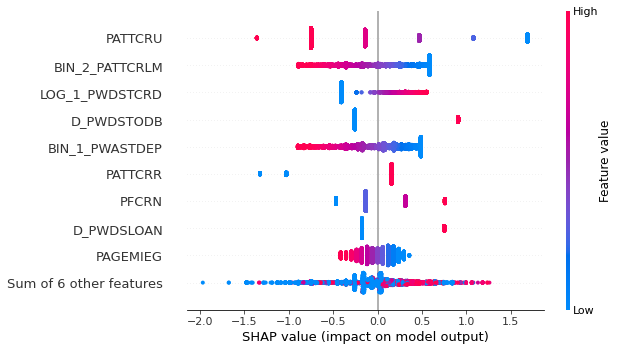

In [42]:
# Sequential Feature Selection: Forward
sfs_fwd_trans_resamp = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, floating=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(trans_resamp_train_X, trans_resamp_train_y)
# Creating a Results DataFrame
fwd_sel_trans_resamp=pd.DataFrame.from_dict(sfs_fwd_trans_resamp.get_metric_dict())
# Getting a list of the best 10 variables
fwd_sel_var_trans_resamp=list(fwd_sel_trans_resamp.loc['feature_names',15])
LogReg_t_rs = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_resamp_train_X[fwd_sel_var_trans_resamp], trans_resamp_train_y)
acc_log_t_rs=classificationSummary(trans_resamp_valid_y, LogReg_t_rs.predict(trans_resamp_valid_X[fwd_sel_var_trans_resamp]))
# AUROC
prob_y = LogReg_t_rs.predict_proba(trans_resamp_valid_X[fwd_sel_var_trans_resamp])
prob_y = [p[1] for p in prob_y]
roc_log_t_rs=roc_auc_score(trans_resamp_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_t_rs_acc_valid=LogReg_t_rs.score(trans_resamp_valid_X[fwd_sel_var_trans_resamp], trans_resamp_valid_y)
LogReg_t_rs_acc_train=LogReg_t_rs.score(trans_resamp_train_X[fwd_sel_var_trans_resamp], trans_resamp_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Trans-Resamp) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}\n".format(roc_log_t_rs,LogReg_t_rs_acc_train,LogReg_t_rs_acc_valid))
explainer = shap.Explainer(LogReg_t_rs, trans_resamp_train_X[fwd_sel_var_trans_resamp], feature_names=trans_resamp_train_X[fwd_sel_var_trans_resamp].columns.tolist())
shap_values = explainer(trans_resamp_train_X[fwd_sel_var_trans_resamp])
shap.plots.beeswarm(shap_values)

In [43]:
# Sequential Feature Selection: Backward
#sfs_fwd_trans_resamp = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
#                                                   class_weight='balanced'), 
#                                forward=False, verbose=2, k_features=10, scoring='roc_auc', n_jobs=-1).fit(trans_resamp_train_X, trans_resamp_train_y)
# Creating a Results DataFrame
#bwd_sel_trans_resamp=pd.DataFrame.from_dict(sfs_fwd_trans_resamp.get_metric_dict())
# Getting a list of the best 10 variables
#bwd_sel_var_trans_resamp=list(bwd_sel_trans_resamp.loc['feature_names',10])
#LogReg_t_rs = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_resamp_train_X[bwd_sel_var_trans_resamp], trans_resamp_train_y)
# AUROC
#prob_y = LogReg_t_rs.predict_proba(trans_resamp_valid_X[bwd_sel_var_trans_resamp])
#prob_y = [p[1] for p in prob_y]
#roc_log_t_rs=roc_auc_score(trans_resamp_valid_y, prob_y)
# Valid and Training Accuracy
#LogReg_t_rs_acc_valid=LogReg_t_rs.score(trans_resamp_valid_X[bwd_sel_var_trans_resamp], trans_resamp_valid_y)
#LogReg_t_rs_acc_train=LogReg_t_rs.score(trans_resamp_train_X[bwd_sel_var_trans_resamp], trans_resamp_train_y)
#print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Trans-Resamp) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_t_rs,LogReg_t_rs_acc_train,LogReg_t_rs_acc_valid))

In [44]:
# Sequential Feature Selection: forward - stepwise
sfs_sw_trans_resamp = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, floating=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(trans_resamp_train_X, trans_resamp_train_y)
# Creating a Results DataFrame
sw_sel_trans_resamp=pd.DataFrame.from_dict(sfs_sw_trans_resamp.get_metric_dict())
# Getting a list of the best 15 variables
sw_sel_var_trans_resamp=list(sw_sel_trans_resamp.loc['feature_names',15])
LogReg_t_rs = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_resamp_train_X[sw_sel_var_trans_resamp], trans_resamp_train_y)
acc_log_t_rs=classificationSummary(trans_resamp_valid_y, LogReg_t_rs.predict(trans_resamp_valid_X[fwd_sel_var_trans_resamp]))
# AUROC
prob_y = LogReg_t_rs.predict_proba(trans_resamp_valid_X[sw_sel_var_trans_resamp])
prob_y = [p[1] for p in prob_y]
roc_log_t_rs=roc_auc_score(trans_resamp_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_t_rs_acc_valid=LogReg_t_rs.score(trans_resamp_valid_X[sw_sel_var_trans_resamp], trans_resamp_valid_y)
LogReg_t_rs_acc_train=LogReg_t_rs.score(trans_resamp_train_X[sw_sel_var_trans_resamp], trans_resamp_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Trans-Resamp) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_t_rs,LogReg_t_rs_acc_train,LogReg_t_rs_acc_valid))

Confusion Matrix (Accuracy 0.7347)

       Prediction
Actual    0    1
     0 3012 1063
     1 1099 2976

Evaluation of the 10 best variables:
    Logistic Regression (Trans-Resamp) VALID AUCROC: 0.8050
    Training Accuracy: 0.7573
    Validation Accuracy: 0.7347


*Neural Network - TRANS-RESAMP*

Initial bias: 0.0
Weight for class 0: 1.00
Weight for class 1: 1.00

Restoring model weights from the end of the best epoch: 130.
Epoch 145: early stopping

Results:
    TN - FN: 3159 / 1358
    FP - TP: 916 / 2717

    Validation Accuracy: 0.721
    Validation AUC_ROC: 0.8012
    Validation Recall: 0.6667
    Precision: 0.7479



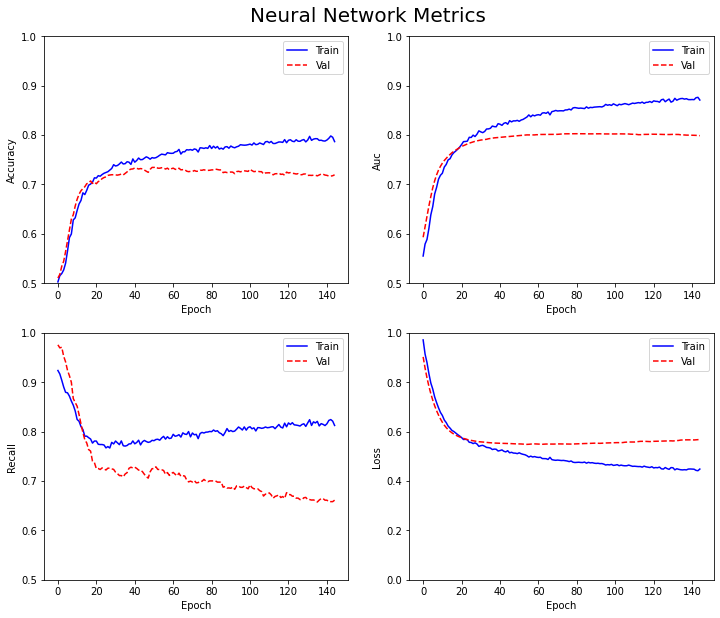

In [45]:
# Data Normalization for NN 
# Create np arrays of labels and features.
train_labels_t_rs = np.array(trans_resamp_train_y)
bool_train_labels_t_rs = train_labels_t_rs != 0
val_labels_t_rs = np.array(trans_resamp_valid_y)
train_features_t_rs = np.array(trans_resamp_train_X)
val_features_t_rs = np.array(trans_resamp_valid_X)
# Normalizing data
scaler = StandardScaler()
train_features_t_rs = scaler.fit_transform(train_features_t_rs)
val_features_t_rs = scaler.transform(val_features_t_rs)
# Eliminating outliers
train_features_t_rs = np.clip(train_features_t_rs, -5, 5)
val_features_t_rs = np.clip(val_features_t_rs, -5, 5)
# Defining positive and negative target responses - will be used to set the weights and bias
pos_df_t_rs = pd.DataFrame(train_features_t_rs[ bool_train_labels_t_rs], columns=trans_resamp_train_X.columns)
neg_df_t_rs = pd.DataFrame(train_features_t_rs[~bool_train_labels_t_rs], columns=trans_resamp_train_X.columns)
neg_t_rs, pos_t_rs = np.bincount(trans_resamp_train_y)
total_t_rs = neg_t_rs + pos_t_rs
# Defining the initial bias of the model - avoiding the model only 'learns' the bias during first epochs there's class 
initial_bias_t_rs = np.log([pos_t_rs/neg_t_rs])
print('Initial bias:', round(initial_bias_t_rs[0],2))
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0_t_rs = (1/neg_t_rs)*(total_t_rs/2.0)
weight_for_1_t_rs = (1/pos_t_rs)*(total_t_rs/2.0)
class_weight_t_rs = {0: weight_for_0_t_rs, 1: weight_for_1_t_rs}
print('Weight for class 0: {:.2f}'.format(weight_for_0_t_rs))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1_t_rs))


                                              # Function: Model - Initial Weights 
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),]
BATCH_SIZE = 2000
# Construct the Model
output_bias_t_rs = tf.keras.initializers.Constant(initial_bias_t_rs)
weights_t_rs = keras.Sequential([
    keras.layers.Dense(12, activation='relu',input_shape=(train_features_t_rs.shape[-1],)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias_t_rs),])
# Compile Model
weights_t_rs.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Evaluate
results_t_rs = weights_t_rs.evaluate(train_features_t_rs, train_labels_t_rs, batch_size=BATCH_SIZE, verbose=0)
initial_weights_t_rs = os.path.join(tempfile.mkdtemp(), 'initial_weights_t_rs')
weights_t_rs.save_weights(initial_weights_t_rs)

                                                     # Function: Model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
# Model
nn_t_rs = keras.Sequential([
    keras.layers.Dense(12, activation='relu',input_shape=(train_features_t_rs.shape[-1],)),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')])
# Compile Model
nn_t_rs.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Defining Additional Model Parameters
EPOCHS = 500
early_stopping_t_rs = tf.keras.callbacks.EarlyStopping(monitor='val_prc',verbose=1,patience=15,mode='max',restore_best_weights=True)
# Fit the model
nn_t_rs.load_weights(initial_weights_t_rs)
nn_t_rs_history = nn_t_rs.fit(
    train_features_t_rs,
    train_labels_t_rs,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping_t_rs],
    validation_data=(val_features_t_rs, val_labels_t_rs),
    class_weight=class_weight_t_rs)

#Evaluate the model
train_predictions_weighted_t_rs = nn_t_rs.predict(train_features_t_rs, batch_size=BATCH_SIZE)
test_predictions_weighted_t_rs = nn_t_rs.predict(val_features_t_rs, batch_size=BATCH_SIZE)

nn_t_rs_results = nn_t_rs.evaluate(val_features_t_rs, val_labels_t_rs, batch_size=BATCH_SIZE, verbose=0)
print('\nResults:\n    TN - FN: {:.0f} / {:.0f}\n    FP - TP: {:.0f} / {:.0f}\n\n    Validation Accuracy: {:.4}\n    Validation AUC_ROC: {:.4}\n    Validation Recall: {:.4}\n    Precision: {:.4}\n'.format(nn_t_rs_results[3],nn_t_rs_results[4],nn_t_rs_results[2],nn_t_rs_results[1],nn_t_rs_results[5],nn_t_rs_results[8],nn_t_rs_results[7],nn_t_rs_results[6]))

# Visuals
metrics = ['accuracy', 'auc','recall','loss']
fig, ax=plt.subplots(2,2, figsize=(12,10))
fig.text(x=0.5, y=0.90, s='Neural Network Metrics', fontsize=20, ha='center')
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(nn_t_rs_history.epoch, nn_t_rs_history.history[metric], color="blue", label='Train')
  plt.plot(nn_t_rs_history.epoch, nn_t_rs_history.history['val_'+metric],color="red", linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  if metric == 'recall':
    plt.ylim([0.5,1])
  elif metric == 'auc':
    plt.ylim([0.5,1])
  elif metric == 'accuracy':
    plt.ylim([0.5,1])
  else:
    plt.ylim([0,1])
  plt.legend();

DATA AUGMENTATION WITH SMOTENC

In [47]:
# Defining X and y
trans_train, trans_valid = train_test_split(trans_data, test_size=0.5, random_state=1)
trans_train_X = trans_train.drop(columns=['PATTSKP'])
trans_train_y = trans_train['PATTSKP']
trans_valid_X = trans_valid.drop(columns=['PATTSKP'])
trans_valid_y = trans_valid['PATTSKP']
# Running SMOTENC
trans_train_X_smote_nc = SMOTENC(categorical_features=[trans_train_X.dtypes=='category'], random_state=0)
trans_syn_train_X,trans_syn_train_y=trans_train_X_smote_nc.fit_resample(trans_train_X,trans_train_y)
trans_valid_X_smote_nc = SMOTENC(categorical_features=[trans_valid_X.dtypes=='category'], random_state=0)
trans_syn_valid_X,trans_syn_valid_y=trans_valid_X_smote_nc.fit_resample(trans_valid_X,trans_valid_y)
# Corroborating there are no null values after running SMOTENC
print('Null values in Feature dataframe:\n')
print(pd.DataFrame(trans_syn_valid_X.isnull().sum()).sort_values(by=[0], ascending=False).head(3))
print('\nNull Values in the Target Variable:',trans_syn_valid_y.isnull().sum())

print('Null values in Feature dataframe:\n')
print(pd.DataFrame(trans_syn_train_X.isnull().sum()).sort_values(by=[0], ascending=False).head(3))
print('\nNull Values in the Target Variable:',trans_syn_train_y.isnull().sum())

Null values in Feature dataframe:

          0
PWASTMUI  0
PASRDPO1  0
PFMTYPG   0

Null Values in the Target Variable: 0
Null values in Feature dataframe:

          0
PWASTMUI  0
PASRDPO1  0
PFMTYPG   0

Null Values in the Target Variable: 0


In [48]:
# Full Classification Tree - TRANS-SYN
fullClassTree_t_syn = DecisionTreeClassifier(random_state=1).fit(trans_syn_train_X,trans_syn_train_y)
acc_fct_t_syn=classificationSummary(trans_syn_valid_y,fullClassTree_t_syn.predict(trans_syn_valid_X))
# AUCROC
prob_y = fullClassTree_t_syn.predict_proba(trans_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_fct_t_syn=roc_auc_score(trans_syn_valid_y,prob_y)
fullClassTree_t_syn_acc_train=fullClassTree_t_syn.score(trans_syn_train_X, trans_syn_train_y)
print("\nAUCROC: {:.4f}\nFull Classification Tree Training Accuracy: {:.2f}".format(roc_fct_t_syn,fullClassTree_t_syn_acc_train))

Confusion Matrix (Accuracy 0.8407)

       Prediction
Actual    0    1
     0 3696  379
     1  919 3156

AUCROC: 0.8407
Full Classification Tree Training Accuracy: 1.00


Confusion Matrix (Accuracy 0.8330)

       Prediction
Actual    0    1
     0 3070 1005
     1  356 3719

Random Forest Classifier (Trans-Syn) AUCROC: 0.9168
Training Accuracy: 0.8515



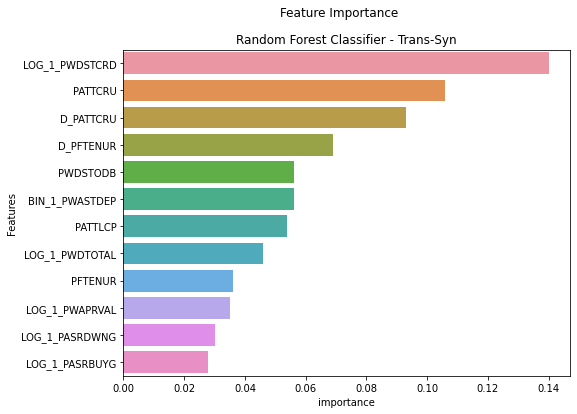

In [49]:
# Random Forest Classifier - TRANS-SYN
rfc_t_syn = RandomForestClassifier(random_state=123, n_estimators=750, max_depth=3).fit(trans_syn_train_X, trans_syn_train_y)
acc_rfc_t_syn=classificationSummary(trans_syn_valid_y, rfc_t_syn.predict(trans_syn_valid_X))
# AUROC
prob_y = rfc_t_syn.predict_proba(trans_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_rfc_t_syn=roc_auc_score(trans_syn_valid_y,prob_y)
rfc_t_syn_acc_train=rfc_t_syn.score(trans_syn_train_X, trans_syn_train_y)
print("\nRandom Forest Classifier (Trans-Syn) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_rfc_t_syn,rfc_t_syn_acc_train))
# Feature Importance
importance= rfc_t_syn.feature_importances_
df= pd.DataFrame({'feature': trans_syn_train_X.columns, 'importance': np.round(importance,3)})
# Feature Importance Plot
selected_imp=df.sort_values('importance', ascending=False)[:12]
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("Random Forest Classifier - Trans-Syn")
plt.show()
print('\n')
selected_imp_rfc_t_syn=selected_imp.feature.tolist()
selected_importances_rfc_t_syn=selected_imp.feature.tolist()

In [50]:
proba_rfc=pd.DataFrame(prob_y,columns=['proba'])
proba_rfc.sort_values(by='proba',ascending=False,inplace=True)
imp_rfc_t_syn=['PEFATINC','PWDSTCRD','PATTCRU','D_PATTCRU','D_PFTENUR','PWASTDEP','PWDSTODB','PWDTOTAL','PATTLCP','PWAPRVAL','PAGEMIEG']
concept=['After Tax Income','Total CC and Installment Debt','CC Balance Paid on Time?','Paid the Minimum or Less?','Owns a Home with No Mortgage?','Total Money in Banks',
         'Total of other Debt','Total Debts of Family','Line of Credit Balance Paid on Time?','Value of Principal Residence','Age of Major Income Earner']
print('                                    HIGH PROBABILITY OF MISSING OR SKIPPING A PAYMENT')
pd.DataFrame({'Concept':concept,'Hi-Proba-1': base_syn_train_X.loc[proba_rfc.head(2).index.values[1],imp_rfc_t_syn].round(),
              'Hi-Proba-2': base_syn_train_X.loc[proba_rfc.head(4).index.values[3],imp_rfc_t_syn].round(),
              'Lo-Proba-1': base_syn_train_X.loc[proba_rfc.tail(2).index.values[0],imp_rfc_t_syn].round(),
              'Lo-Proba-2': base_syn_train_X.loc[proba_rfc.tail(1).index.values[0],imp_rfc_t_syn].round(),
              'Max':base_syn_train_X[imp_rfc_t_syn].max().round(),
              'Min':base_syn_train_X[imp_rfc_t_syn].min().round(),
              'Mean':base_syn_train_X[imp_rfc_t_syn].mean().round()}, index=imp_rfc_t_syn)

                                    HIGH PROBABILITY OF MISSING OR SKIPPING A PAYMENT


,Concept,Hi-Proba-1,Hi-Proba-2,Lo-Proba-1,Lo-Proba-2,Max,Min,Mean
PEFATINC,After Tax Income,47682.0,61708.0,27000.0,152700.0,232120.0,-26000.0,71199.0
PWDSTCRD,Total CC and Installment Debt,2307.0,1241.0,0.0,0.0,24162.0,0.0,2919.0
PATTCRU,CC Balance Paid on Time?,4.0,0.0,3.0,1.0,NaN,NaN,NaN
D_PATTCRU,Paid the Minimum or Less?,0.0,0.0,1.0,1.0,NaN,NaN,NaN
D_PFTENUR,Owns a Home with No Mortgage?,0.0,0.0,0.0,0.0,NaN,NaN,NaN
PWASTDEP,Total Money in Banks,4248.0,88.0,900.0,1000.0,221297.0,-3200.0,12520.0
PWDSTODB,Total of other Debt,1320.0,394.0,0.0,0.0,8050.0,0.0,674.0
PWDTOTAL,Total Debts of Family,16090.0,1635.0,14000.0,117500.0,636230.0,0.0,107091.0
PATTLCP,Line of Credit Balance Paid on Time?,0.0,0.0,3.0,0.0,NaN,NaN,NaN
PWAPRVAL,Value of Principal Residence,0.0,0.0,0.0,300000.0,1257136.0,0.0,237959.0


Confusion Matrix (Accuracy 0.9128)

       Prediction
Actual    0    1
     0 3996   79
     1  632 3443

AdaBoost Decision Tree Classifier (Trans-Syn) AUCROC: 0.9615
Training Accuracy: 1.0000



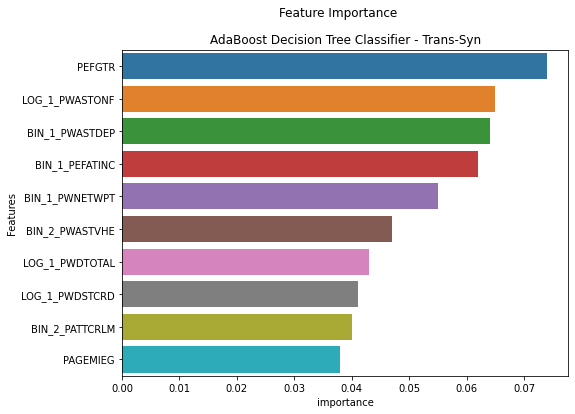



                                    HIGH PROBABILITY OF MISSING OR SKIPPING A PAYMENT


,Concept,Hi-Inc Hi-Proba,Lo-Inc Hi-Proba,Hi-Inc Lo-Proba,Lo-Inc Lo-Proba,Max,Min,Mean
PEFGTR,Government Transfer,20298.0,15514.0,9000.0,14000.0,49326.0,0.0,10843.0
PEFATINC,After-Tax Income,76962.0,111779.0,69250.0,51250.0,232120.0,-26000.0,71199.0
PWASTONF,Other Non-Financial Assets,4671.0,12845.0,19000.0,4750.0,184793.0,175.0,17702.0
PWASTDEP,Total Money in Banks,891.0,3588.0,200.0,2900.0,221297.0,-3200.0,12520.0
PATTCRLM,Total Credit Limit (CC),0.0,15230.0,5250.0,8750.0,88534.0,0.0,15228.0
PWASTVHE,Total Debt on Vehicles,1272.0,954.0,70000.0,5750.0,96432.0,0.0,18566.0
PWNETWPT,Net Worth of Family,6780.0,389393.0,232450.0,11505.0,2831148.0,-910500.0,485644.0
PWDTOTAL,Total Debts of Family,54.0,138347.0,338250.0,1900.0,636230.0,0.0,107091.0
PAGEMIEG,Age of Major Income Earner,25.0,47.0,54.0,39.0,84.0,19.0,50.0
PWDSTCRD,Total CC and Installment Debt,0.0,2484.0,0.0,1900.0,24162.0,0.0,2919.0


In [52]:
# AdaBoost Decision Tree Classifier - TRANS-RESAMP
ada_t_syn=AdaBoostClassifier(DecisionTreeClassifier(random_state=123, max_depth=3),n_estimators=750, random_state=1).fit(trans_syn_train_X, trans_syn_train_y)
acc_ada_t_syn=classificationSummary(trans_syn_valid_y, ada_t_syn.predict(trans_syn_valid_X))
# AUROC
prob_y = ada_t_syn.predict_proba(trans_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_ada_t_syn=roc_auc_score(trans_syn_valid_y, prob_y)
ada_t_syn_acc_train=ada_t_syn.score(trans_syn_train_X, trans_syn_train_y)
print("\nAdaBoost Decision Tree Classifier (Trans-Syn) AUCROC: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_ada_t_syn,ada_t_syn_acc_train))
# Feature Importance
importance= ada_t_syn.feature_importances_
df= pd.DataFrame({'feature': trans_syn_train_X.columns, 'importance': np.round(importance,3)})
selected_imp=df.sort_values('importance', ascending=False)[:10]
# Feature Importance Plot
dist, ax=plt.subplots(figsize=(8,6))
ax1=sns.barplot(x = selected_imp['importance'], y = selected_imp['feature'])
ax1=plt.ylabel('Features')
dist.suptitle("Feature Importance")
ax1=plt.title("AdaBoost Decision Tree Classifier - Trans-Syn")
plt.show()
print('\n')
selected_importances_ada_t_syn=selected_imp.feature.tolist()
#printing Insights DataFrame
proba_ada=pd.DataFrame(prob_y,columns=['proba'])
proba_ada.sort_values(by='proba',ascending=False,inplace=True)
imp_ada_t_syn=['PEFGTR','PEFATINC','PWASTONF','PWASTDEP','PATTCRLM','PWASTVHE','PWNETWPT','PWDTOTAL','PAGEMIEG','PWDSTCRD']
concept=['Government Transfer','After-Tax Income','Other Non-Financial Assets','Total Money in Banks','Total Credit Limit (CC)',
         'Total Debt on Vehicles','Net Worth of Family','Total Debts of Family','Age of Major Income Earner','Total CC and Installment Debt']
print('                                    HIGH PROBABILITY OF MISSING OR SKIPPING A PAYMENT')
pd.DataFrame({'Concept':concept,'Hi-Inc Hi-Proba': base_syn_train_X.loc[proba_ada.head(1).index.values[0],imp_ada_t_syn].round(),
              'Lo-Inc Hi-Proba': base_syn_train_X.loc[proba_ada.head(5).index.values[4],imp_ada_t_syn].round(),
              'Hi-Inc Lo-Proba': base_syn_train_X.loc[proba_ada.tail(9).index.values[0],imp_ada_t_syn].round(),
              'Lo-Inc Lo-Proba': base_syn_train_X.loc[proba_ada.tail(1).index.values[0],imp_ada_t_syn].round(),
              'Max':base_syn_train_X[imp_ada_t_syn].max().round(),
              'Min':base_syn_train_X[imp_ada_t_syn].min().round(),
              'Mean':base_syn_train_X[imp_ada_t_syn].mean().round()}, index=imp_ada_t_syn)

Confusion Matrix (Accuracy 0.8070)

       Prediction
Actual    0    1
     0 3347  728
     1  845 3230

Logistic Regression (Base-Syn) AUCROC: 0.8901
Training Recall: 0.7926
Training Accuracy: 0.8508



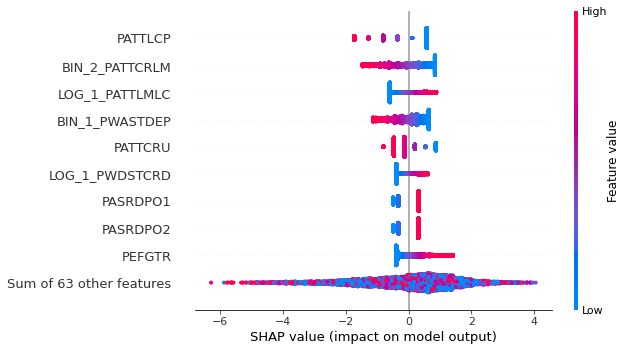



Validation Roc Curve for Full Regression



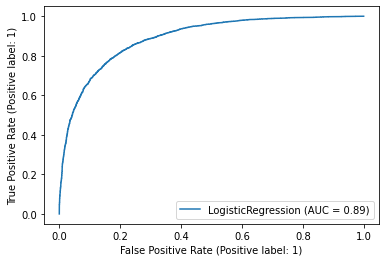

In [53]:
# Logistic Regression - TRANS-Syn
LogReg_t_syn = LogisticRegression(max_iter=1000000, solver='liblinear', class_weight='balanced').fit(trans_syn_train_X, trans_syn_train_y)
acc_log_t_syn=classificationSummary(trans_syn_valid_y, LogReg_t_syn.predict(trans_syn_valid_X))
# AUROC
prob_y = LogReg_t_syn.predict_proba(trans_syn_valid_X)
prob_y = [p[1] for p in prob_y]
roc_log_t_syn=roc_auc_score(trans_syn_valid_y, prob_y)
LogReg_t_syn_acc_train=LogReg_t_syn.score(trans_syn_train_X, trans_syn_train_y)
pred_val_y_t_syn_valid_full=LogReg_t_syn.predict(trans_syn_valid_X)
recall_t_syn_acc_valid_full=recall_score(trans_syn_valid_y,pred_val_y_t_syn_valid_full)
print("\nLogistic Regression (Base-Syn) AUCROC: {:.4f}\nTraining Recall: {:.4f}\nTraining Accuracy: {:.4f}\n".format(roc_log_t_syn,recall_t_syn_acc_valid_full,LogReg_t_syn_acc_train))
#results=sm.Logit(trans_syn_valid_y,trans_syn_valid_X).fit()
#print(results.summary())
explainer = shap.Explainer(LogReg_t_syn, trans_syn_train_X, feature_names=trans_syn_train_X.columns.tolist())
shap_values = explainer(trans_syn_train_X)
import warnings
warnings.filterwarnings('ignore')
shap.plots.beeswarm(shap_values)
print('\n')
print('Validation Roc Curve for Full Regression\n')
fig=plot_roc_curve(LogReg_t_syn,trans_syn_valid_X,trans_syn_valid_y)


*Sequential Feature Selection, Estimator: Logistic Regression, Data: Base-RESAMP*

Confusion Matrix (Accuracy 0.8064)

       Prediction
Actual    0    1
     0 3311  764
     1  814 3261

Evaluation of the 10 best variables:
    Logistic Regression (Base-Syn) VALID AUCROC: 0.8910
    Validation Recall: 0.8002
    Training Accuracy: 0.8413
    Validation Accuracy: 0.8064



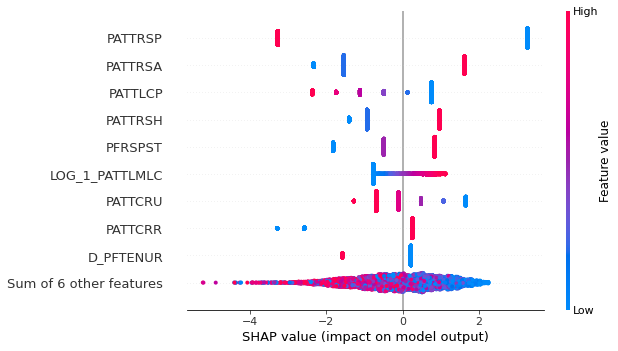



Optimization terminated successfully.
         Current function value: 0.367063
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                PATTSKP   No. Observations:                 8238
Model:                          Logit   Df Residuals:                     8223
Method:                           MLE   Df Model:                           14
Date:                Fri, 05 Aug 2022   Pseudo R-squ.:                  0.4704
Time:                        19:00:00   Log-Likelihood:                -3023.9
converged:                       True   LL-Null:                       -5710.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
PATTLCP           -0.6208      0.035    -17.857      0.000      -0.689      -0.553
BIN_2_PATTCRLM 

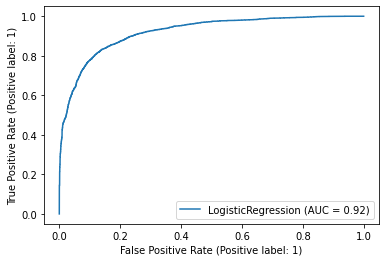

In [54]:
# Sequential Feature Selection: Forward
sfs_fwd_trans_syn = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(trans_syn_train_X, trans_syn_train_y)
# Creating a Results DataFrame
fwd_sel_trans_syn=pd.DataFrame.from_dict(sfs_fwd_trans_syn.get_metric_dict())
# Getting a list of the best 10 variables
fwd_sel_var_trans_syn=list(fwd_sel_trans_syn.loc['feature_names',15])
LogReg_t_syn = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_syn_train_X[fwd_sel_var_trans_syn], trans_syn_train_y)
acc_log_t_syn=classificationSummary(trans_syn_valid_y, LogReg_t_syn.predict(trans_syn_valid_X[fwd_sel_var_trans_syn]))
# AUROC
prob_y = LogReg_t_syn.predict_proba(trans_syn_valid_X[fwd_sel_var_trans_syn])
prob_y = [p[1] for p in prob_y]
roc_log_t_syn=roc_auc_score(trans_syn_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_t_syn_acc_valid=LogReg_t_syn.score(trans_syn_valid_X[fwd_sel_var_trans_syn], trans_syn_valid_y)
LogReg_t_syn_acc_train=LogReg_t_syn.score(trans_syn_train_X[fwd_sel_var_trans_syn], trans_syn_train_y)
pred_val_y_t_syn_valid=LogReg_t_syn.predict(trans_syn_valid_X[fwd_sel_var_trans_syn])
recall_t_syn_acc_valid=recall_score(trans_syn_valid_y,pred_val_y_t_syn_valid)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Syn) VALID AUCROC: {:.4f}\n    Validation Recall: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}\n".format(roc_log_t_syn,recall_t_syn_acc_valid,LogReg_t_syn_acc_train,LogReg_t_syn_acc_valid))
explainer = shap.Explainer(LogReg_t_syn, trans_syn_valid_X[fwd_sel_var_trans_syn], feature_names=trans_syn_valid_X[fwd_sel_var_trans_syn].columns.tolist())
shap_values = explainer(trans_syn_valid_X[fwd_sel_var_trans_syn])
shap.plots.beeswarm(shap_values)
print('\n')
# ALL VARIABLES SELECTED BY THE FORWARD INCLUSION AND STEPWISE FEATURE SELECTION METHODS CAME BACK AS STATISTICALLY SIGNIFICANT
results=sm.Logit(trans_syn_train_y,trans_syn_train_X[fwd_sel_var_trans_syn]).fit()
print(results.summary())
# AUC CURVE for Logistic Regression with Selected Features
print('AUC ROC curve for Logistic Regression: Selected Features\n')
fig=plot_roc_curve(LogReg_t_syn,trans_syn_train_X[fwd_sel_var_trans_syn],trans_syn_train_y)

In [55]:
# Sequential Feature Selection: Backward
#sfs_fwd_trans_syn = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
#                                                   class_weight='balanced'), 
#                                forward=false, verbose=2, k_features=10, scoring='roc_auc', n_jobs=-1).fit(trans_syn_train_X, trans_syn_train_y)
# Creating a Results DataFrame
#fwd_sel_trans_syn=pd.DataFrame.from_dict(sfs_fwd_trans_syn.get_metric_dict())
# Getting a list of the best 10 variables
#fwd_sel_var_trans_syn=list(fwd_sel_trans_syn.loc['feature_names',10])
#LogReg_t_syn = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_syn_train_X[fwd_sel_var_trans_syn], trans_syn_train_y)
# AUROC
#prob_y = LogReg_t_syn.predict_proba(trans_syn_valid_X[fwd_sel_var_trans_syn])
#prob_y = [p[1] for p in prob_y]
#roc_log_t_syn=roc_auc_score(trans_syn_valid_y, prob_y)
# Valid and Training Accuracy
#LogReg_t_syn_acc_valid=LogReg_t_syn.score(trans_syn_valid_X[fwd_sel_var_trans_syn], trans_syn_valid_y)
#LogReg_t_syn_acc_train=LogReg_t_syn.score(trans_syn_train_X[fwd_sel_var_trans_syn], trans_syn_train_y)
#print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Syn) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_t_syn,LogReg_t_syn_acc_train,LogReg_t_syn_acc_valid))

In [56]:
# Sequential Feature Selection: Forward
sfs_fwd_trans_syn = SFS(LogisticRegression(max_iter=1000, solver='liblinear', 
                                                   class_weight='balanced'), 
                                forward=True, floating=True, verbose=0, k_features=15, scoring='roc_auc', n_jobs=-1).fit(trans_syn_train_X, trans_syn_train_y)
# Creating a Results DataFrame
fwd_sel_trans_syn=pd.DataFrame.from_dict(sfs_fwd_trans_syn.get_metric_dict())
# Getting a list of the best 10 variables
fwd_sel_var_trans_syn=list(fwd_sel_trans_syn.loc['feature_names',15])
LogReg_t_syn = LogisticRegression(max_iter=1000000, class_weight='balanced', solver='liblinear').fit(trans_syn_train_X[fwd_sel_var_trans_syn], trans_syn_train_y)
acc_log_t_syn=classificationSummary(trans_syn_valid_y, LogReg_t_syn.predict(trans_syn_valid_X[fwd_sel_var_trans_syn]))
# AUROC
prob_y = LogReg_t_syn.predict_proba(trans_syn_valid_X[fwd_sel_var_trans_syn])
prob_y = [p[1] for p in prob_y]
roc_log_t_syn=roc_auc_score(trans_syn_valid_y, prob_y)
# Valid and Training Accuracy
LogReg_t_syn_acc_valid=LogReg_t_syn.score(trans_syn_valid_X[fwd_sel_var_trans_syn], trans_syn_valid_y)
LogReg_t_syn_acc_train=LogReg_t_syn.score(trans_syn_train_X[fwd_sel_var_trans_syn], trans_syn_train_y)
print("\nEvaluation of the 10 best variables:\n    Logistic Regression (Base-Syn) VALID AUCROC: {:.4f}\n    Training Accuracy: {:.4f}\n    Validation Accuracy: {:.4f}".format(roc_log_t_syn,LogReg_t_syn_acc_train,LogReg_t_syn_acc_valid))

Confusion Matrix (Accuracy 0.8064)

       Prediction
Actual    0    1
     0 3311  764
     1  814 3261

Evaluation of the 10 best variables:
    Logistic Regression (Base-Syn) VALID AUCROC: 0.8910
    Training Accuracy: 0.8413
    Validation Accuracy: 0.8064


*Neural Network - Base-SYN*

Initial bias: 0.0
Weight for class 0: 1.00
Weight for class 1: 1.00

Restoring model weights from the end of the best epoch: 316.
Epoch 331: early stopping

Results:
    TN - FN: 3760 / 712
    FP - TP: 315 / 3363

    Validation Accuracy: 0.874
    Validation AUC_ROC: 0.9499
    Validation Recall: 0.8253
    Precision: 0.9144



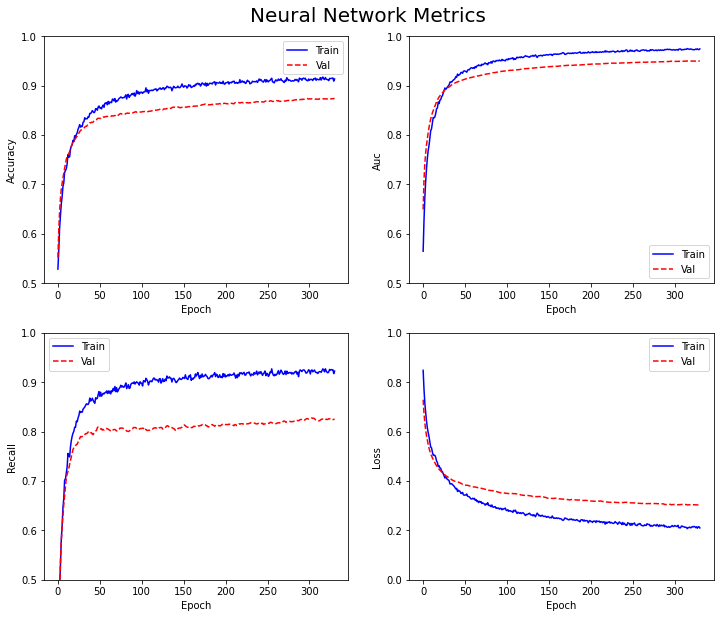

In [57]:
# Data Normalization for NN 
# Create np arrays of labels and features.
train_labels_t_syn = np.array(trans_syn_train_y)
bool_train_labels_t_syn = train_labels_t_syn != 0
val_labels_t_syn = np.array(trans_syn_valid_y)
train_features_t_syn = np.array(trans_syn_train_X)
val_features_t_syn = np.array(trans_syn_valid_X)
# Normalizing data
scaler = StandardScaler()
train_features_t_syn = scaler.fit_transform(train_features_t_syn)
val_features_t_syn = scaler.transform(val_features_t_syn)
# Eliminating outliers
train_features_t_syn = np.clip(train_features_t_syn, -5, 5)
val_features_t_syn = np.clip(val_features_t_syn, -5, 5)
# Defining positive and negative target responses - will be used to set the weights and bias
pos_df_t_syn = pd.DataFrame(train_features_t_syn[ bool_train_labels_t_syn], columns=trans_syn_valid_X.columns)
neg_df_t_syn = pd.DataFrame(train_features_t_syn[~bool_train_labels_t_syn], columns=trans_syn_valid_X.columns)
neg_t_syn, pos_t_syn = np.bincount(trans_syn_train_y)
total_t_syn = neg_t_syn + pos_t_syn
# Defining the initial bias of the model - avoiding the model only 'learns' the bias during first epochs there's class 
initial_bias_t_syn = np.log([pos_t_syn/neg_t_syn])
print('Initial bias:', round(initial_bias_t_syn[0],2))
# Scaling by total/2 helps keep the loss to a similar magnitude.
weight_for_0_t_syn = (1/neg_t_syn)*(total_t_syn/2.0)
weight_for_1_t_syn = (1/pos_t_syn)*(total_t_syn/2.0)
class_weight_t_syn = {0: weight_for_0_t_syn, 1: weight_for_1_t_syn}
print('Weight for class 0: {:.2f}'.format(weight_for_0_t_syn))
print('Weight for class 1: {:.2f}\n'.format(weight_for_1_t_syn))


                                              # Function: Model - Initial Weights 
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),]
BATCH_SIZE = 2000
# Construct the Model
output_bias_t_syn = tf.keras.initializers.Constant(initial_bias_t_syn)
weights_t_syn = keras.Sequential([
    keras.layers.Dense(16, activation='relu',input_shape=(train_features_t_syn.shape[-1],)),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias_t_syn),])
# Compile Model
weights_t_syn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Evaluate
results_t_syn = weights_t_syn.evaluate(train_features_t_syn, train_labels_t_syn, batch_size=BATCH_SIZE, verbose=0)
initial_weights_t_syn = os.path.join(tempfile.mkdtemp(), 'initial_weights_t_syn')
weights_t_syn.save_weights(initial_weights_t_syn)

                                                     # Function: Model
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]
# Model
nn_t_syn = keras.Sequential([
    keras.layers.Dense(16, activation='relu',input_shape=(train_features_t_syn.shape[-1],)),
    keras.layers.Dropout(0.45),
    keras.layers.Dense(1, activation='sigmoid')])
# Compile Model
nn_t_syn.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=METRICS)
# Defining Additional Model Parameters
EPOCHS = 500
early_stopping_t_syn = tf.keras.callbacks.EarlyStopping(monitor='val_prc',verbose=1,patience=15,mode='max',restore_best_weights=True)
# Fit the model
nn_t_syn.load_weights(initial_weights_t_syn)
nn_t_syn_history = nn_t_syn.fit(
    train_features_t_syn,
    train_labels_t_syn,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0,
    callbacks=[early_stopping_t_syn],
    validation_data=(val_features_t_syn, val_labels_t_syn),
    class_weight=class_weight_t_syn)

#Evaluate the model
train_predictions_weighted_t_syn = nn_t_syn.predict(train_features_t_syn, batch_size=BATCH_SIZE)
test_predictions_weighted_t_syn = nn_t_syn.predict(val_features_t_syn, batch_size=BATCH_SIZE)

nn_t_syn_results = nn_t_syn.evaluate(val_features_t_syn, val_labels_t_syn, batch_size=BATCH_SIZE, verbose=0)
print('\nResults:\n    TN - FN: {:.0f} / {:.0f}\n    FP - TP: {:.0f} / {:.0f}\n\n    Validation Accuracy: {:.4}\n    Validation AUC_ROC: {:.4}\n    Validation Recall: {:.4}\n    Precision: {:.4}\n'.format(nn_t_syn_results[3],nn_t_syn_results[4],nn_t_syn_results[2],nn_t_syn_results[1],nn_t_syn_results[5],nn_t_syn_results[8],nn_t_syn_results[7],nn_t_syn_results[6]))

# Visuals
metrics = ['accuracy', 'auc','recall','loss']
fig, ax=plt.subplots(2,2, figsize=(12,10))
fig.text(x=0.5, y=0.90, s='Neural Network Metrics', fontsize=20, ha='center')
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(nn_t_syn_history.epoch, nn_t_syn_history.history[metric], color="blue", label='Train')
  plt.plot(nn_t_syn_history.epoch, nn_t_syn_history.history['val_'+metric],color="red", linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  if metric == 'recall':
    plt.ylim([0.5,1])
  elif metric == 'auc':
    plt.ylim([0.5,1])
  elif metric == 'accuracy':
    plt.ylim([0.5,1])
  else:
    plt.ylim([0,1])
  plt.legend();

          BASE DATA - DATA AUGMENTATION:RESAMPLING 
Negative Instance - Importances Ranked in Order of Importance



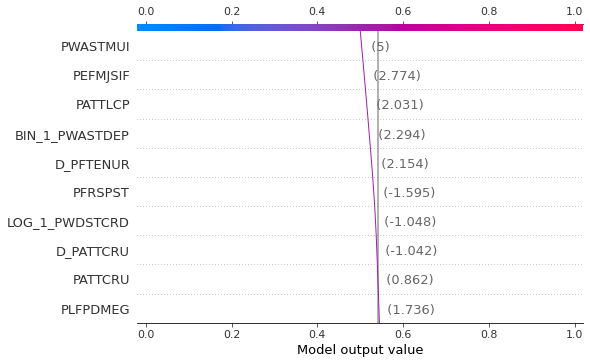



         BASE DATA - DATA AUGMENTATION:RESAMPLING 
Positive Instance - Importances Ranked in Order of Importance



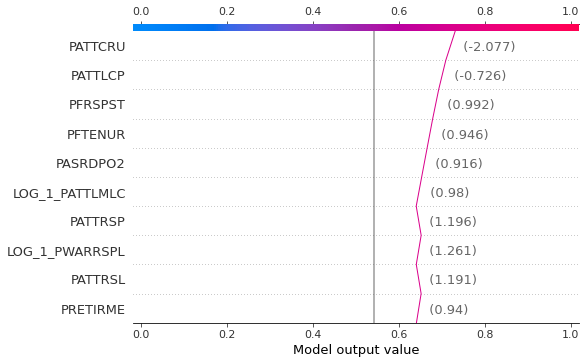

In [58]:
# Creating a dataframe of the predictions in order
nn_pred=pd.DataFrame(test_predictions_weighted_t_syn, columns=['pred']).sort_values(by='pred', ascending=False)
# Plotting Shap Visual
print('          BASE DATA - DATA AUGMENTATION:RESAMPLING ')
print('Negative Instance - Importances Ranked in Order of Importance\n')
nam=trans_syn_train_X.columns.tolist()
i=nn_pred.tail(10).index.values[0]
explainer_shap(nn_t_syn, 
               X_names=nam, 
               X_instance=val_features_t_syn[i], 
               X_train=val_features_t_syn, 
               task="classification",
               top=10)
print('\n')
print('         BASE DATA - DATA AUGMENTATION:RESAMPLING ')
print('Positive Instance - Importances Ranked in Order of Importance\n')
i=nn_pred.head(1).index.values[0]
explainer_shap(nn_t_syn, 
               X_names=nam, 
               X_instance=val_features_t_syn[i], 
               X_train=val_features_t_syn, 
               task="classification",
               top=10)